# Imports

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import pearsonr
from scipy.stats import f_oneway, chi2_contingency

In [54]:
DATA_PATH = "./train_test_set.csv"
df = pd.read_csv(DATA_PATH, index_col=False)

C:\Users\tarek\AppData\Local\Temp\ipykernel_26912\2385585698.py:2: DtypeWarning: Columns (23,35,38,60) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH, index_col=False)


# Data Preparation

In [55]:
df = df.loc[:, ~df.columns.str.contains('Unnamed')]

In [56]:
pd.set_option('display.max_columns', None)

1. delete columns that semantically do not make sense

In [57]:
# delete columns that semantically do not make sense
coll_remove = ['usr_diagnostiqueur_id',
               'usr_logiciel_id',
               'tr001_modele_dpe_id',
               'version_methode_dpe',
               'tr002_type_batiment_code',
               'tr001_modele_dpe_fichier_vierge',
               'commune',
               'code_postal',
               'code_insee_commune',
               'code_insee_commune_actualise',
               'organisme_certificateur',
               'adresse_organisme_certificateur',
               'geo_adresse',
               'geo_id',
               'geo_l4',
               'geo_type',
               'tr002_type_batiment_id',
               'tr001_modele_dpe_type_ordre',
               'tr002_type_batiment_description',
               'nom_rue',
               'tr001_modele_dpe_type_id',
               'tr001_modele_dpe_description',
               'dpe_vierge',       
               'explication_personnalisee',
               'date_reception_dpe',        
               'date_visite_diagnostiqueur',
               'date_etablissement_dpe',
               'date_arrete_tarifs_energies',
               'arrondissement',
               'tr002_type_batiment_simulateur',
               'numero_dpe',
               'en_surface',
               'tr001_modele_dpe_type_libelle',
               'type_voie',
               'numero_lot',
               'portee_dpe_batiment',
               'tr012_categorie_erp_id',
               'tr013_type_erp_id',
               'numero_rue',
               'batiment',
               'escalier',
               'etage',
               'porte',
               'commentaires_ameliorations_recommandations',
               'shon'
               ]

### remove unecessary columns

In [58]:
len(coll_remove)
# Suppression des colonnes du DataFrame
df = df.drop(columns=coll_remove)

In [59]:
df

nom_methode_dpe nom_methode_etude_thermique  \
0           Méthode 3CL                         NaN   
1          TROIS_CL_DPE                         NaN   
2             3CL - DPE                         NaN   
3               FACTURE                         NaN   
4         FACTURE - DPE                         NaN   
...                 ...                         ...   
125466        3CL - DPE                         NaN   
125467        3CL - DPE                         NaN   
125468  Méthode Facture                         NaN   
125469      Méthode 3CL                         NaN   
125470        3CL - DPE                         NaN   

       version_methode_etude_thermique  consommation_energie  estimation_ges  \
0                                  NaN                201.00            8.00   
1                                  NaN                209.64            9.71   
2                                  NaN                177.12            5.77   
3                                  NaN                234.04           54.76   
4                                  NaN                161.25           37.73   
...                                ...                   ...             ...   
125466                             NaN                275.81           14.49   
125467                             NaN                151.22           35.38   
125468                             NaN                377.00           12.00   
125469                             NaN                273.00           16.00   
125470                             NaN                224.47            5.05   

                                     secteur_activite  annee_construction  \
0                                                 NaN                1989   
1                                                 NaN                2001   
2       Habitation (Parties privatives d'immeuble col                1900   
3                                                 NaN                1900   
4                                                 NaN                1974   
...                                               ...                 ...   
125466                                            NaN                1982   
125467                                            NaN                1982   
125468                                            NaN                1947   
125469                                            NaN                1983   
125470             Habitation (Maisons individuelles)                1900   

        surface_habitable  surface_thermique_lot quote_part  \
0                   58.53                  58.53        NaN   
1                  130.00                 130.00        NaN   
2                   43.00                  43.00        NaN   
3                   93.00                  93.00        NaN   
4                   17.13                  17.13        NaN   
...                   ...                    ...        ...   
125466              79.00                  79.00        NaN   
125467              98.00                  98.00        NaN   
125468              32.05                  32.05        NaN   
125469             174.00                 174.00        NaN   
125470             150.50                 150.50        NaN   

        surface_commerciale_contractuelle partie_batiment  surface_utile  \
0                                     NaN             NaN            0.0   
1                                     NaN             NaN          130.0   
2                                     NaN             NaN            0.0   
3                                     NaN             NaN           93.0   
4                                     NaN             NaN            NaN   
...                                   ...             ...            ...   
125466                                NaN             NaN            NaN   
125467                                NaN             NaN            NaN   
125468              

2. suppression des lignes avec des valeurs manquantes seuil de 70%

In [60]:
def custom_info(df, alpha):
    """
    Prints a DataFrame summary with the percentage of null values for each column.
    If a column has more than alpha% null values, it is added to a list and returned.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        alpha (float): Threshold percentage of null values to filter columns.

    Returns:
        list: Columns with more than alpha% null values.
    """
    assert alpha >= 0 and alpha <= 1, "alpha must be a percentage between 0 and 1."
    alpha = alpha # Convert percentage to fraction
    null_percentage = df.isnull().mean() # Calculate percentage of null values
    column_types = df.dtypes
    memory_usage = df.memory_usage(deep=True).sum()
    high_null_columns = []  # List to store columns exceeding alpha% null values

    print(f"<class 'pandas.core.frame.DataFrame'>")
    print(f"RangeIndex: {len(df)} entries")
    print(f"Data columns (total {len(df.columns)} columns):")
    print(f" #   Column          Dtype    Null Percentage")
    print(f"---  ------          -----    ---------------")

    for i, (col, dtype) in enumerate(column_types.items()):
        null_pct = null_percentage[col]
        if null_pct > alpha:
            high_null_columns.append(col)
        print(f"{i:>3}  {col:<15} {str(dtype):<8} {null_pct:>10.10f}%")

    print(f"dtypes: {', '.join(sorted(set(map(str, df.dtypes))))}")
    print(f"memory usage: {memory_usage / 1024:.2f} KB")

    return high_null_columns

nan_percentage_threshold = 0.7
null_columns = custom_info(df, alpha=nan_percentage_threshold)
null_columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125471 entries
Data columns (total 29 columns):
 #   Column          Dtype    Null Percentage
---  ------          -----    ---------------
  0  nom_methode_dpe object   0.0000000000%
  1  nom_methode_etude_thermique object   0.8311243235%
  2  version_methode_etude_thermique object   0.8642395454%
  3  consommation_energie float64  0.0000000000%
  4  estimation_ges  float64  0.0000000000%
  5  secteur_activite object   0.8214487810%
  6  annee_construction int64    0.0000000000%
  7  surface_habitable float64  0.0000796997%
  8  surface_thermique_lot float64  0.0000796997%
  9  quote_part      object   0.9976010393%
 10  surface_commerciale_contractuelle float64  0.9138605734%
 11  partie_batiment object   0.9999282703%
 12  surface_utile   float64  0.2884810036%
 13  nombre_niveaux  float64  0.2884810036%
 14  surface_baies_orientees_nord float64  0.2984992548%
 15  surface_baies_orientees_est_ouest float64  0.2984992548%
 16  surface

['nom_methode_etude_thermique',
 'version_methode_etude_thermique',
 'secteur_activite',
 'quote_part',
 'surface_commerciale_contractuelle',
 'partie_batiment',
 'geo_l5']

### remove columns that contain plus then 70% of nan values

In [61]:
null_columns = ['nom_methode_etude_thermique',
 'version_methode_etude_thermique',
 'secteur_activite',
 'quote_part',
 'surface_commerciale_contractuelle',
 'partie_batiment',
 'geo_l5']

In [62]:
df = df.drop(columns=null_columns)

In [63]:
df

nom_methode_dpe  consommation_energie  estimation_ges  \
0           Méthode 3CL                201.00            8.00   
1          TROIS_CL_DPE                209.64            9.71   
2             3CL - DPE                177.12            5.77   
3               FACTURE                234.04           54.76   
4         FACTURE - DPE                161.25           37.73   
...                 ...                   ...             ...   
125466        3CL - DPE                275.81           14.49   
125467        3CL - DPE                151.22           35.38   
125468  Méthode Facture                377.00           12.00   
125469      Méthode 3CL                273.00           16.00   
125470        3CL - DPE                224.47            5.05   

        annee_construction  surface_habitable  surface_thermique_lot  \
0                     1989              58.53                  58.53   
1                     2001             130.00                 130.00   
2                     1900              43.00                  43.00   
3                     1900              93.00                  93.00   
4                     1974              17.13                  17.13   
...                    ...                ...                    ...   
125466                1982              79.00                  79.00   
125467                1982              98.00                  98.00   
125468                1947              32.05                  32.05   
125469                1983             174.00                 174.00   
125470                1900             150.50                 150.50   

        surface_utile  nombre_niveaux  surface_baies_orientees_nord  \
0                 0.0             1.0                          5.26   
1               130.0             1.0                          0.00   
2                 0.0             0.0                          0.00   
3                93.0             1.0                          0.00   
4                 NaN             NaN                           NaN   
...               ...             ...                           ...   
125466            NaN             NaN                           NaN   
125467            NaN             NaN                           NaN   
125468            0.0             1.0                          0.00   
125469            0.0             1.0                          0.00   
125470            0.0             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_baies_orientees_sud  \
0                                     0.0                         5.84   
1                                     0.0                         0.00   
2                                     0.0                         0.00   
3                                     0.0                         0.00   
4                                     NaN                          NaN   
...                                   ...                          ...   
125466                                NaN                          NaN   
125467                                NaN                          NaN   
125468                                0.0                         0.00   
125469                               19.9                         0.00   
125470                                0.0                         0.00   

        surface_planchers_hauts_deperditifs  \
0                                      0.00   
1                                      0.00   
2                                      0.00   
3                                      0.00   
4                                       NaN   
...                                     ...   
125466                                  NaN   
125467                                  NaN   
125468                                 0.00   
125469                               164.33   
125470                                 0.00   

        surface_planchers_bas_deperditifs  \
0         

### calculate the ratio of each line and remove lines that contain plus then 40 % of NAN values

In [64]:
# Charger le dataset
dfTest = df

# Calculer le pourcentage de valeurs manquantes pour chaque ligne
missing_percentage = dfTest.isnull().sum(axis=1) / dfTest.shape[1] * 100

# Ajouter cette information dans le dataframe
dfTest["%_missing"] = missing_percentage

# Afficher les 10 premières lignes avec le pourcentage de valeurs manquantes
dfTest

nom_methode_dpe  consommation_energie  estimation_ges  \
0           Méthode 3CL                201.00            8.00   
1          TROIS_CL_DPE                209.64            9.71   
2             3CL - DPE                177.12            5.77   
3               FACTURE                234.04           54.76   
4         FACTURE - DPE                161.25           37.73   
...                 ...                   ...             ...   
125466        3CL - DPE                275.81           14.49   
125467        3CL - DPE                151.22           35.38   
125468  Méthode Facture                377.00           12.00   
125469      Méthode 3CL                273.00           16.00   
125470        3CL - DPE                224.47            5.05   

        annee_construction  surface_habitable  surface_thermique_lot  \
0                     1989              58.53                  58.53   
1                     2001             130.00                 130.00   
2                     1900              43.00                  43.00   
3                     1900              93.00                  93.00   
4                     1974              17.13                  17.13   
...                    ...                ...                    ...   
125466                1982              79.00                  79.00   
125467                1982              98.00                  98.00   
125468                1947              32.05                  32.05   
125469                1983             174.00                 174.00   
125470                1900             150.50                 150.50   

        surface_utile  nombre_niveaux  surface_baies_orientees_nord  \
0                 0.0             1.0                          5.26   
1               130.0             1.0                          0.00   
2                 0.0             0.0                          0.00   
3                93.0             1.0                          0.00   
4                 NaN             NaN                           NaN   
...               ...             ...                           ...   
125466            NaN             NaN                           NaN   
125467            NaN             NaN                           NaN   
125468            0.0             1.0                          0.00   
125469            0.0             1.0                          0.00   
125470            0.0             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_baies_orientees_sud  \
0                                     0.0                         5.84   
1                                     0.0                         0.00   
2                                     0.0                         0.00   
3                                     0.0                         0.00   
4                                     NaN                          NaN   
...                                   ...                          ...   
125466                                NaN                          NaN   
125467                                NaN                          NaN   
125468                                0.0                         0.00   
125469                               19.9                         0.00   
125470                                0.0                         0.00   

        surface_planchers_hauts_deperditifs  \
0                                      0.00   
1                                      0.00   
2                                      0.00   
3                                      0.00   
4                                       NaN   
...                                     ...   
125466                                  NaN   
125467                                  NaN   
125468                                 0.00   
125469                               164.33   
125470                                 0.00   

        surface_planchers_bas_deperditifs  \
0         

In [65]:
# Définir le seuil de pourcentage de valeurs manquantes
seuil = 40

# Supprimer les lignes où le pourcentage de valeurs nulles est supérieur au seuil
df_cleaned = dfTest[dfTest["%_missing"] <= seuil]

df_cleaned = df_cleaned.drop(columns=["%_missing"])

In [66]:
df_cleaned

nom_methode_dpe  consommation_energie  estimation_ges  \
0           Méthode 3CL                201.00            8.00   
1          TROIS_CL_DPE                209.64            9.71   
2             3CL - DPE                177.12            5.77   
3               FACTURE                234.04           54.76   
5             3CL - DPE                278.63           13.89   
...                 ...                   ...             ...   
125466        3CL - DPE                275.81           14.49   
125467        3CL - DPE                151.22           35.38   
125468  Méthode Facture                377.00           12.00   
125469      Méthode 3CL                273.00           16.00   
125470        3CL - DPE                224.47            5.05   

        annee_construction  surface_habitable  surface_thermique_lot  \
0                     1989              58.53                  58.53   
1                     2001             130.00                 130.00   
2                     1900              43.00                  43.00   
3                     1900              93.00                  93.00   
5                     1974             128.89                 128.89   
...                    ...                ...                    ...   
125466                1982              79.00                  79.00   
125467                1982              98.00                  98.00   
125468                1947              32.05                  32.05   
125469                1983             174.00                 174.00   
125470                1900             150.50                 150.50   

        surface_utile  nombre_niveaux  surface_baies_orientees_nord  \
0                 0.0             1.0                          5.26   
1               130.0             1.0                          0.00   
2                 0.0             0.0                          0.00   
3                93.0             1.0                          0.00   
5                 NaN             NaN                           NaN   
...               ...             ...                           ...   
125466            NaN             NaN                           NaN   
125467            NaN             NaN                           NaN   
125468            0.0             1.0                          0.00   
125469            0.0             1.0                          0.00   
125470            0.0             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_baies_orientees_sud  \
0                                     0.0                         5.84   
1                                     0.0                         0.00   
2                                     0.0                         0.00   
3                                     0.0                         0.00   
5                                     NaN                          NaN   
...                                   ...                          ...   
125466                                NaN                          NaN   
125467                                NaN                          NaN   
125468                                0.0                         0.00   
125469                               19.9                         0.00   
125470                                0.0                         0.00   

        surface_planchers_hauts_deperditifs  \
0                                      0.00   
1                                      0.00   
2                                      0.00   
3                                      0.00   
5                                       NaN   
...                                     ...   
125466                                  NaN   
125467                                  NaN   
125468                                 0.00   
125469                               164.33   
125470                                 0.00   

        surface_planchers_bas_deperditifs  \
0         

3. spliting dataset in 3 DF 'qualitative', 'quantitative', 'categorical'

In [67]:
def classify_columns(df, ordinal_threshold=15):
    """
    Classifies columns in a DataFrame into quantitative, qualitative, and categorical.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    ordinal_threshold (int): The maximum number of unique values to consider a numerical column as qualitative.
    
    Returns:
    dict: Classification of columns.
    pd.DataFrame: DataFrame representation of classification.
    pd.DataFrame: Quantitative columns DataFrame.
    pd.DataFrame: Qualitative columns DataFrame.
    pd.DataFrame: Categorical columns DataFrame.
    """
    # Classification des colonnes
    quantitative_col = df.select_dtypes(include=[int, 'float64']).columns.tolist()
    categorical_col = df.select_dtypes(include=['object']).columns.tolist()
    
    # Identifier les colonnes qualitatives
    qualitative_col = [col for col in quantitative_col if df[col].nunique() < ordinal_threshold]
    
    # Retirer les qualitatives de la liste des quantitatives
    quantitative_col = [col for col in quantitative_col if col not in qualitative_col]
    
    # Classification sous forme de dictionnaire
    classification = {
        "Quantitative Columns": quantitative_col,
        "Qualitative Columns": qualitative_col,
        "Categorical Columns": categorical_col
    }
    
    # DataFrame pour affichage
    classification_df = pd.DataFrame([(k, ", ".join(v)) for k, v in classification.items()], columns=["Type", "Columns"])
    
    # Diviser le DataFrame en trois sous-ensembles
    quantitative_df = df[quantitative_col]
    qualitative_df = df[qualitative_col]
    categorical_df = df[categorical_col]
    
    return classification, classification_df, quantitative_df, qualitative_df, categorical_df


In [68]:
classification, classification_df, quantitative_df, qualitative_df, categorical_df = classify_columns(df_cleaned)

In [69]:
quantitative_df

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00                1989   
1                     209.64            9.71                2001   
2                     177.12            5.77                1900   
3                     234.04           54.76                1900   
5                     278.63           13.89                1974   
...                      ...             ...                 ...   
125466                275.81           14.49                1982   
125467                151.22           35.38                1982   
125468                377.00           12.00                1947   
125469                273.00           16.00                1983   
125470                224.47            5.05                1900   

        surface_habitable  surface_thermique_lot  surface_utile  \
0                   58.53                  58.53            0.0   
1                  130.00                 130.00          130.0   
2                   43.00                  43.00            0.0   
3                   93.00                  93.00           93.0   
5                  128.89                 128.89            NaN   
...                   ...                    ...            ...   
125466              79.00                  79.00            NaN   
125467              98.00                  98.00            NaN   
125468              32.05                  32.05            0.0   
125469             174.00                 174.00            0.0   
125470             150.50                 150.50            0.0   

        nombre_niveaux  surface_baies_orientees_nord  \
0                  1.0                          5.26   
1                  1.0                          0.00   
2                  0.0                          0.00   
3                  1.0                          0.00   
5                  NaN                           NaN   
...                ...                           ...   
125466             NaN                           NaN   
125467             NaN                           NaN   
125468             1.0                          0.00   
125469             1.0                          0.00   
125470             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_baies_orientees_sud  \
0                                     0.0                         5.84   
1                                     0.0                         0.00   
2                                     0.0                         0.00   
3                                     0.0                         0.00   
5                                     NaN                          NaN   
...                                   ...                          ...   
125466                                NaN                          NaN   
125467                                NaN                          NaN   
125468                                0.0                         0.00   
125469                               19.9                         0.00   
125470                                0.0                         0.00   

        surface_planchers_hauts_deperditifs  \
0                                      0.00   
1                                      0.00   
2                                      0.00   
3                                      0.00   
5                                       NaN   
...                                     ...   
125466                                  NaN   
125467                                  NaN   
125468                                 0.00   
125469                               164.33   
125470                                 0.00   

        surface_planchers_bas_deperditifs  \
0                                    0.00   
1                                    0.00   
2                                    0.00   
3                                    0.00   
5                                 

In [70]:
qualitative_df

tr002_type_batiment_ordre
0                               2
1                               1
2                               2
3                               1
5                               1
...                           ...
125466                          1
125467                          1
125468                          2
125469                          1
125470                          1

[122937 rows x 1 columns]

In [71]:
categorical_df

nom_methode_dpe tr001_modele_dpe_code tr001_modele_dpe_modele  \
0           Méthode 3CL                    V1                     6.1   
1          TROIS_CL_DPE                    V1                     6.1   
2             3CL - DPE                    L2                     6.B   
3               FACTURE                    V2                     6.2   
5             3CL - DPE                    V1                     6.1   
...                 ...                   ...                     ...   
125466        3CL - DPE                    V1                     6.1   
125467        3CL - DPE                    V1                     6.1   
125468  Méthode Facture                    L2                     6.B   
125469      Méthode 3CL                    V1                     6.1   
125470        3CL - DPE                    V2                     6.2   

       tr001_modele_dpe_type tr002_type_batiment_libelle  
0                      Vente                 Appartement  
1                      Vente                      Maison  
2                   Location                 Appartement  
3                      Vente                      Maison  
5                      Vente                      Maison  
...                      ...                         ...  
125466                 Vente                      Maison  
125467                 Vente                      Maison  
125468              Location                 Appartement  
125469                 Vente                      Maison  
125470                 Vente                      Maison  

[122937 rows x 5 columns]

4. détecter les colonnes dupliquées

In [72]:
# détecter les colonnes dupliquées dans quantitative_df
duplicate_cols = quantitative_df.T[quantitative_df.T.duplicated()].index
print(f"Duplicate Columns: {duplicate_cols}")
quantitative_df = quantitative_df.drop(duplicate_cols, axis=1)

Duplicate Columns: Index(['surface_thermique_lot'], dtype='object')


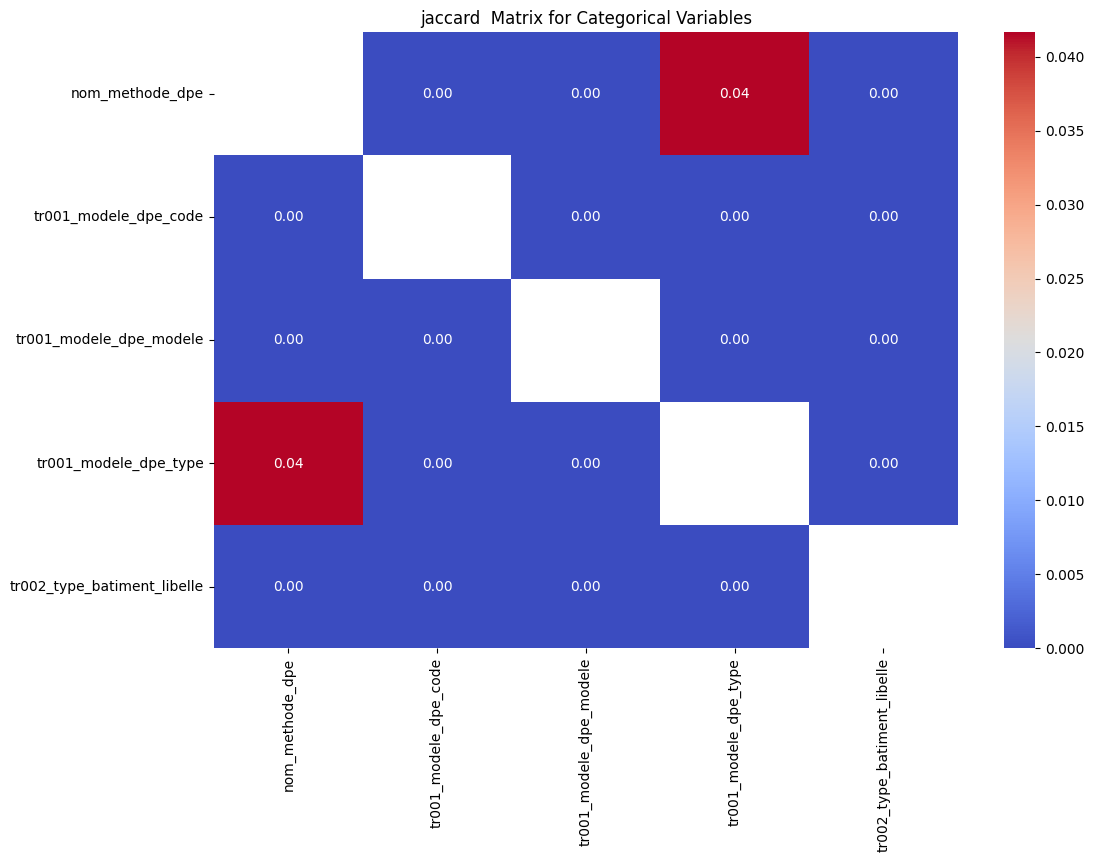

In [73]:
# Jaccard similarity for categorical columns detection de similarité entre les colonnes catégorielles

categorical_cols = categorical_df.columns
def jaccard_similarity(col1, col2):
    set1 = set(col1.dropna().unique())
    set2 = set(col2.dropna().unique())
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Apply Jaccard similarity to categorical columns
jaccard_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            jaccard_matrix.loc[col1, col2] = jaccard_similarity(categorical_df[col1], categorical_df[col2])

jaccard_matrix = jaccard_matrix.astype(float)

plt.figure(figsize=(12, 8))
sns.heatmap(jaccard_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('jaccard  Matrix for Categorical Variables')
plt.show()

### detection des outliers 

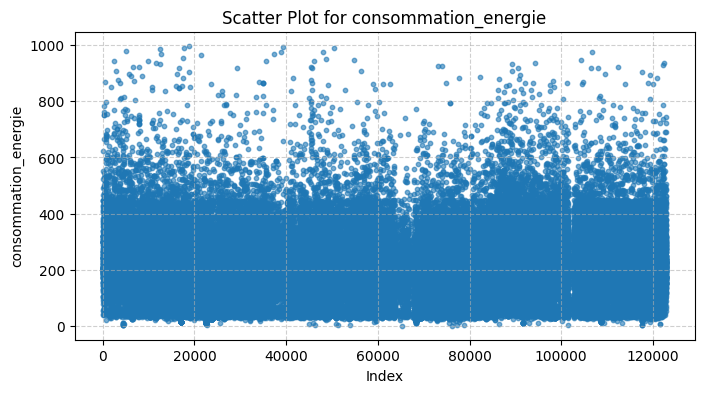

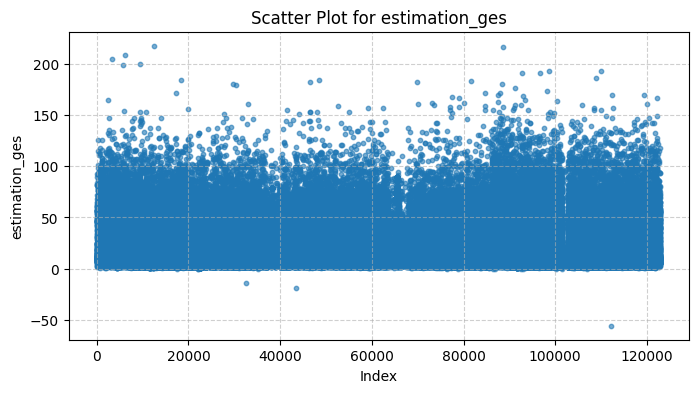

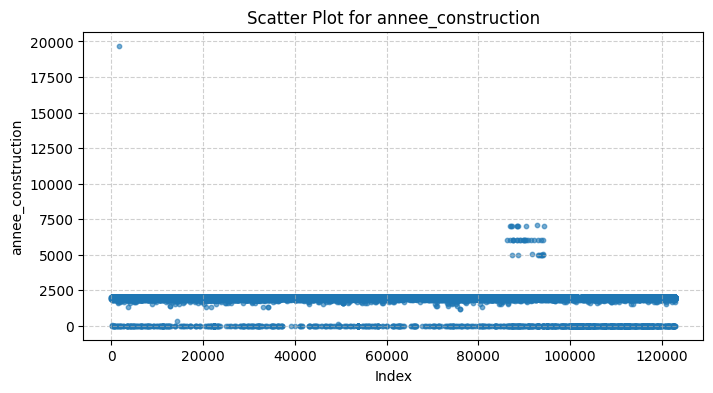

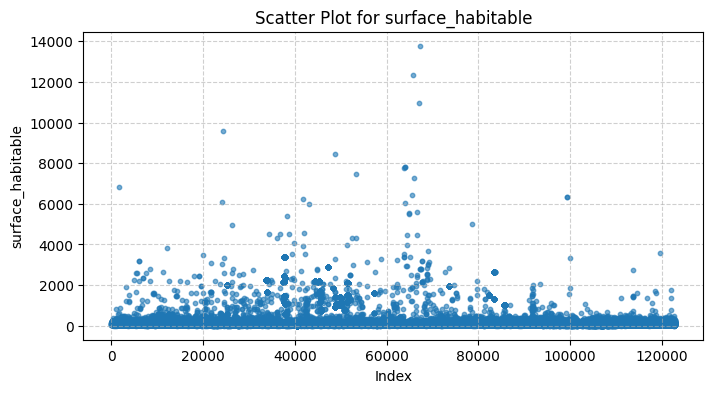

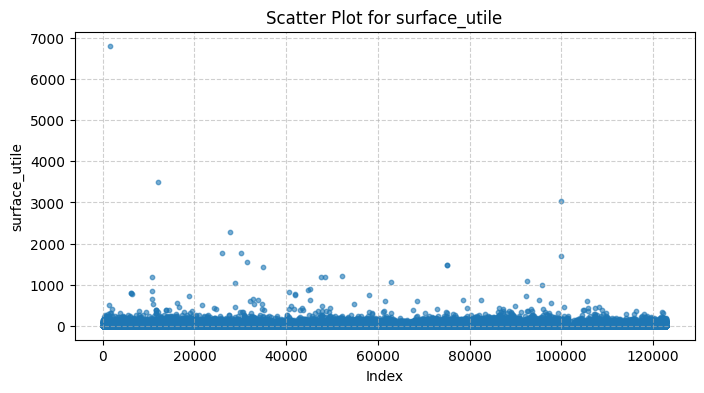

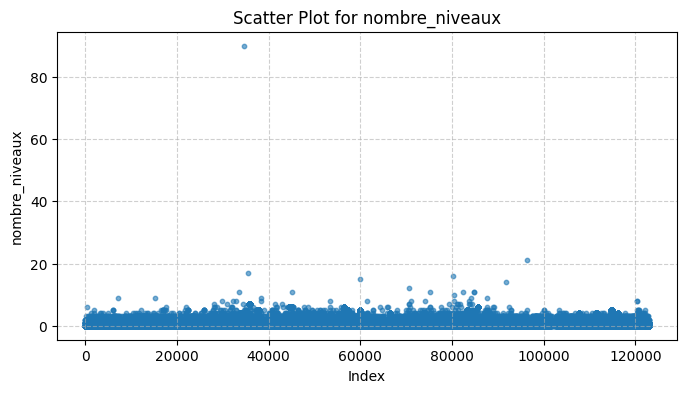

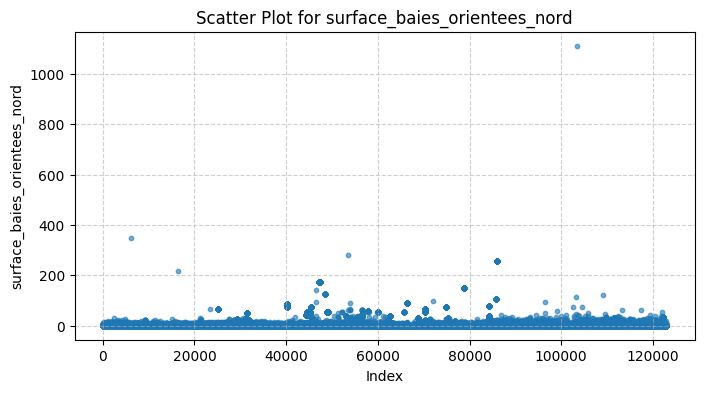

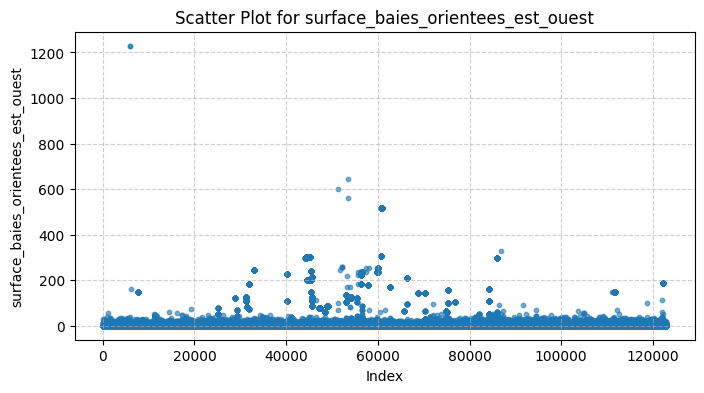

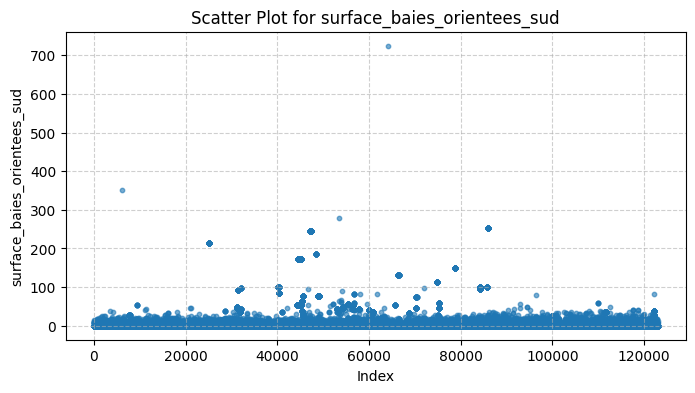

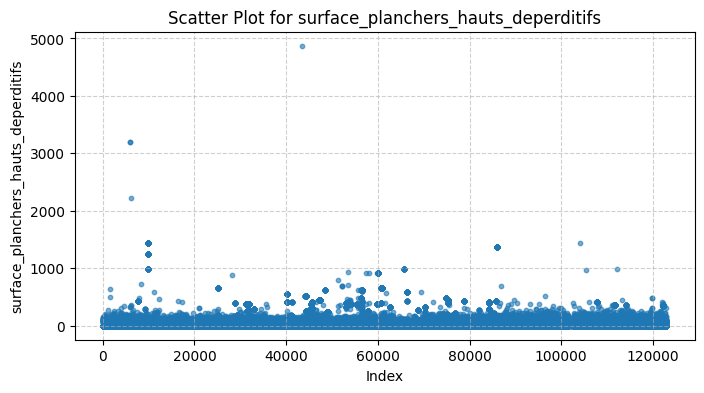

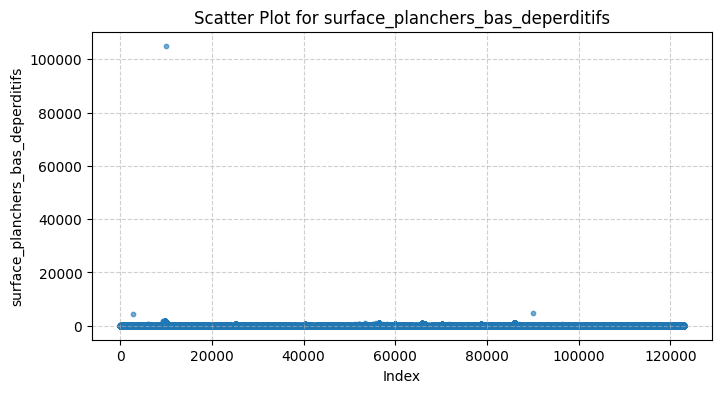

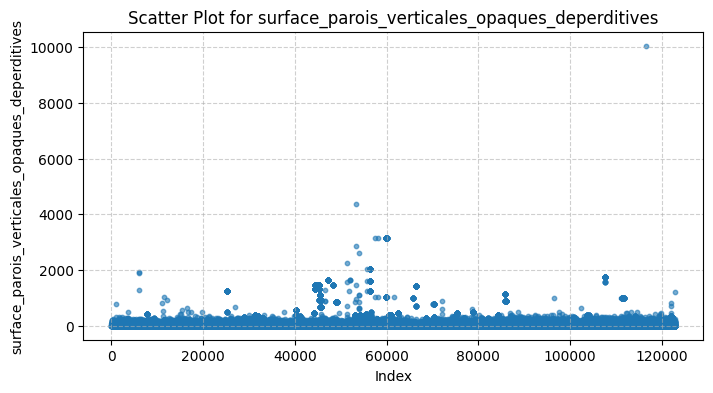

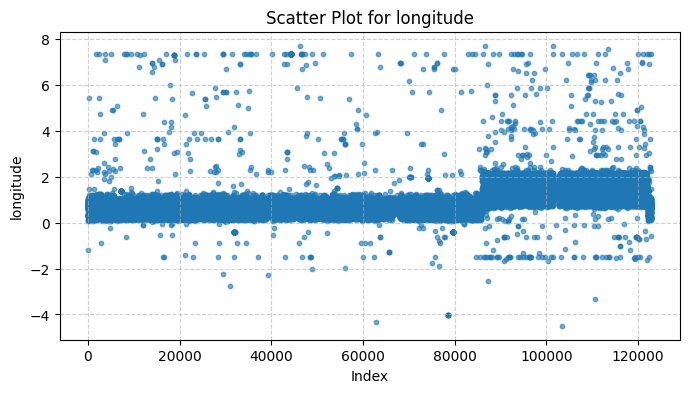

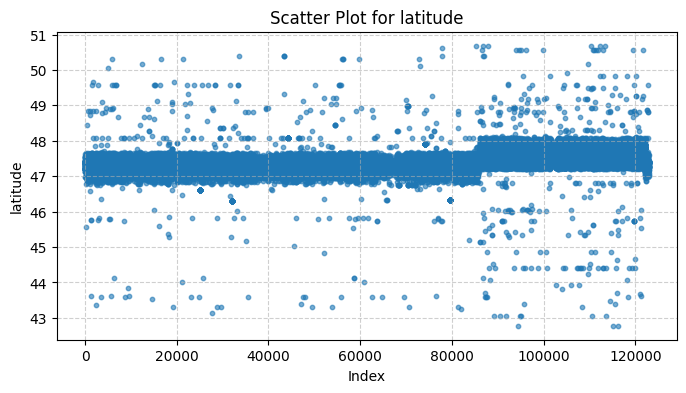

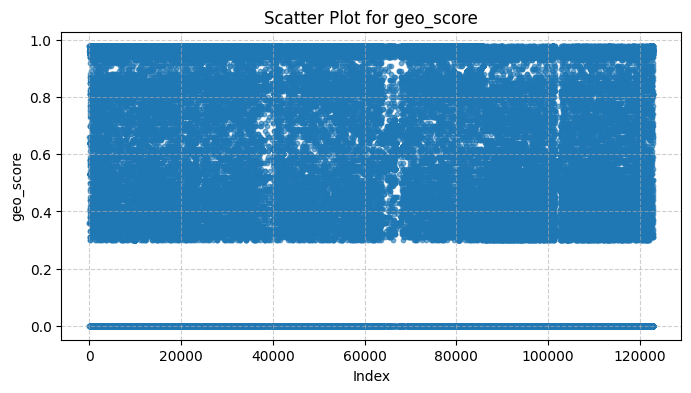

In [74]:
# Generate a scatter plot for each quantitative column
for column in quantitative_df.columns:
    plt.figure(figsize=(8, 4))
    plt.scatter(range(len(quantitative_df[column])), quantitative_df[column], alpha=0.6, s=10)
    plt.title(f"Scatter Plot for {column}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

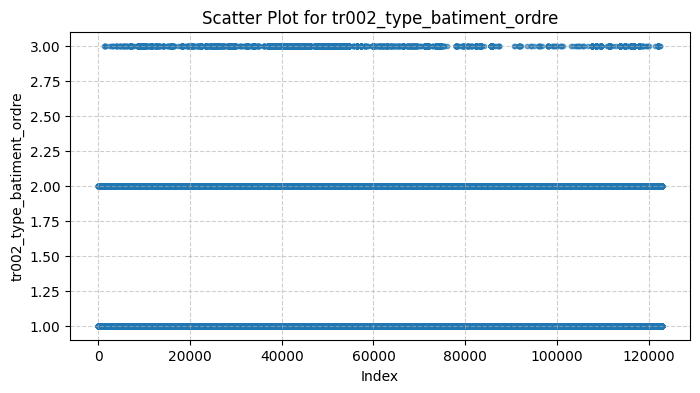

In [75]:
# Generate a scatter plot for each quantitative column
for column in qualitative_df.columns:
    plt.figure(figsize=(8, 4))
    plt.scatter(range(len(qualitative_df[column])), qualitative_df[column], alpha=0.6, s=10)
    plt.title(f"Scatter Plot for {column}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

### outliers isolation

In [76]:
import scipy.stats as stats

# remove outliers from quantitative_df and qualitative_df
def remove_outliers(df, columns, threshold=3):
    """
    Removes outliers from a DataFrame based on the Z-score.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): The list of columns to check for outliers.
        threshold (int): The Z-score threshold for detecting outliers.

    Returns:
        pd.DataFrame: The DataFrame with outliers removed.
    """
    z_scores = np.abs(stats.zscore(df[columns]))
    df = df[(z_scores < threshold).all(axis=1)]
    return df

In [77]:
quantitative_df1 = remove_outliers(quantitative_df, columns=['annee_construction'])

quantitative_df1

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00                1989   
1                     209.64            9.71                2001   
2                     177.12            5.77                1900   
3                     234.04           54.76                1900   
5                     278.63           13.89                1974   
...                      ...             ...                 ...   
125466                275.81           14.49                1982   
125467                151.22           35.38                1982   
125468                377.00           12.00                1947   
125469                273.00           16.00                1983   
125470                224.47            5.05                1900   

        surface_habitable  surface_utile  nombre_niveaux  \
0                   58.53            0.0             1.0   
1                  130.00          130.0             1.0   
2                   43.00            0.0             0.0   
3                   93.00           93.0             1.0   
5                  128.89            NaN             NaN   
...                   ...            ...             ...   
125466              79.00            NaN             NaN   
125467              98.00            NaN             NaN   
125468              32.05            0.0             1.0   
125469             174.00            0.0             1.0   
125470             150.50            0.0             0.0   

        surface_baies_orientees_nord  surface_baies_orientees_est_ouest  \
0                               5.26                                0.0   
1                               0.00                                0.0   
2                               0.00                                0.0   
3                               0.00                                0.0   
5                                NaN                                NaN   
...                              ...                                ...   
125466                           NaN                                NaN   
125467                           NaN                                NaN   
125468                          0.00                                0.0   
125469                          0.00                               19.9   
125470                          0.00                                0.0   

        surface_baies_orientees_sud  surface_planchers_hauts_deperditifs  \
0                              5.84                                 0.00   
1                              0.00                                 0.00   
2                              0.00                                 0.00   
3                              0.00                                 0.00   
5                               NaN                                  NaN   
...                             ...                                  ...   
125466                          NaN                                  NaN   
125467                          NaN                                  NaN   
125468                         0.00                                 0.00   
125469                         0.00                               164.33   
125470                         0.00                                 0.00   

        surface_planchers_bas_deperditifs  \
0                                    0.00   
1                                    0.00   
2                                    0.00   
3                                    0.00   
5                                     NaN   
...                                   ...   
125466                                NaN   
125467                                NaN   
125468                               0.00   
125469                             113.59   
125470                               0.00   

        surface_parois_verticales_opaques_deperditives  longitude   latitude  \
0                                  

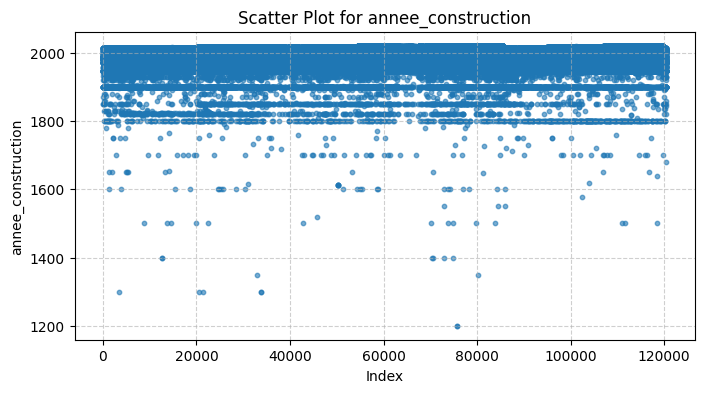

In [78]:
plt.figure(figsize=(8, 4))
plt.scatter(range(len(quantitative_df1['annee_construction'])), quantitative_df1['annee_construction'], alpha=0.6, s=10)
plt.title("Scatter Plot for annee_construction")
plt.xlabel("Index")
plt.ylabel("annee_construction")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

1. merged data after first process

In [79]:
merged_data = pd.concat([quantitative_df1, qualitative_df, categorical_df], axis=1)

In [80]:
merged_data

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00              1989.0   
1                     209.64            9.71              2001.0   
2                     177.12            5.77              1900.0   
3                     234.04           54.76              1900.0   
5                     278.63           13.89              1974.0   
...                      ...             ...                 ...   
125260                   NaN             NaN                 NaN   
125268                   NaN             NaN                 NaN   
125376                   NaN             NaN                 NaN   
125459                   NaN             NaN                 NaN   
125462                   NaN             NaN                 NaN   

        surface_habitable  surface_utile  nombre_niveaux  \
0                   58.53            0.0             1.0   
1                  130.00          130.0             1.0   
2                   43.00            0.0             0.0   
3                   93.00           93.0             1.0   
5                  128.89            NaN             NaN   
...                   ...            ...             ...   
125260                NaN            NaN             NaN   
125268                NaN            NaN             NaN   
125376                NaN            NaN             NaN   
125459                NaN            NaN             NaN   
125462                NaN            NaN             NaN   

        surface_baies_orientees_nord  surface_baies_orientees_est_ouest  \
0                               5.26                                0.0   
1                               0.00                                0.0   
2                               0.00                                0.0   
3                               0.00                                0.0   
5                                NaN                                NaN   
...                              ...                                ...   
125260                           NaN                                NaN   
125268                           NaN                                NaN   
125376                           NaN                                NaN   
125459                           NaN                                NaN   
125462                           NaN                                NaN   

        surface_baies_orientees_sud  surface_planchers_hauts_deperditifs  \
0                              5.84                                  0.0   
1                              0.00                                  0.0   
2                              0.00                                  0.0   
3                              0.00                                  0.0   
5                               NaN                                  NaN   
...                             ...                                  ...   
125260                          NaN                                  NaN   
125268                          NaN                                  NaN   
125376                          NaN                                  NaN   
125459                          NaN                                  NaN   
125462                          NaN                                  NaN   

        surface_planchers_bas_deperditifs  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
5                                     NaN   
...                                   ...   
125260                                NaN   
125268                                NaN   
125376                                NaN   
125459                                NaN   
125462                                NaN   

        surface_parois_verticales_opaques_deperditives  longitude   latitude  \
0                                  

In [81]:
# Charger le dataset
dfTest = merged_data

# Calculer le pourcentage de valeurs manquantes pour chaque ligne
missing_percentage = dfTest.isnull().sum(axis=1) / dfTest.shape[1] * 100

# Ajouter cette information dans le dataframe
dfTest["%_missing"] = missing_percentage

# Afficher les 10 premières lignes avec le pourcentage de valeurs manquantes
dfTest

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00              1989.0   
1                     209.64            9.71              2001.0   
2                     177.12            5.77              1900.0   
3                     234.04           54.76              1900.0   
5                     278.63           13.89              1974.0   
...                      ...             ...                 ...   
125260                   NaN             NaN                 NaN   
125268                   NaN             NaN                 NaN   
125376                   NaN             NaN                 NaN   
125459                   NaN             NaN                 NaN   
125462                   NaN             NaN                 NaN   

        surface_habitable  surface_utile  nombre_niveaux  \
0                   58.53            0.0             1.0   
1                  130.00          130.0             1.0   
2                   43.00            0.0             0.0   
3                   93.00           93.0             1.0   
5                  128.89            NaN             NaN   
...                   ...            ...             ...   
125260                NaN            NaN             NaN   
125268                NaN            NaN             NaN   
125376                NaN            NaN             NaN   
125459                NaN            NaN             NaN   
125462                NaN            NaN             NaN   

        surface_baies_orientees_nord  surface_baies_orientees_est_ouest  \
0                               5.26                                0.0   
1                               0.00                                0.0   
2                               0.00                                0.0   
3                               0.00                                0.0   
5                                NaN                                NaN   
...                              ...                                ...   
125260                           NaN                                NaN   
125268                           NaN                                NaN   
125376                           NaN                                NaN   
125459                           NaN                                NaN   
125462                           NaN                                NaN   

        surface_baies_orientees_sud  surface_planchers_hauts_deperditifs  \
0                              5.84                                  0.0   
1                              0.00                                  0.0   
2                              0.00                                  0.0   
3                              0.00                                  0.0   
5                               NaN                                  NaN   
...                             ...                                  ...   
125260                          NaN                                  NaN   
125268                          NaN                                  NaN   
125376                          NaN                                  NaN   
125459                          NaN                                  NaN   
125462                          NaN                                  NaN   

        surface_planchers_bas_deperditifs  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
5                                     NaN   
...                                   ...   
125260                                NaN   
125268                                NaN   
125376                                NaN   
125459                                NaN   
125462                                NaN   

        surface_parois_verticales_opaques_deperditives  longitude   latitude  \
0                                  

In [82]:
# Définir le seuil de pourcentage de valeurs manquantes
seuil = 60

# Supprimer les lignes où le pourcentage de valeurs nulles est supérieur au seuil
df_cleaned = dfTest[dfTest["%_missing"] <= seuil]

df_cleaned = df_cleaned.drop(columns=["%_missing"])

In [83]:
df_cleaned

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00              1989.0   
1                     209.64            9.71              2001.0   
2                     177.12            5.77              1900.0   
3                     234.04           54.76              1900.0   
5                     278.63           13.89              1974.0   
...                      ...             ...                 ...   
125466                275.81           14.49              1982.0   
125467                151.22           35.38              1982.0   
125468                377.00           12.00              1947.0   
125469                273.00           16.00              1983.0   
125470                224.47            5.05              1900.0   

        surface_habitable  surface_utile  nombre_niveaux  \
0                   58.53            0.0             1.0   
1                  130.00          130.0             1.0   
2                   43.00            0.0             0.0   
3                   93.00           93.0             1.0   
5                  128.89            NaN             NaN   
...                   ...            ...             ...   
125466              79.00            NaN             NaN   
125467              98.00            NaN             NaN   
125468              32.05            0.0             1.0   
125469             174.00            0.0             1.0   
125470             150.50            0.0             0.0   

        surface_baies_orientees_nord  surface_baies_orientees_est_ouest  \
0                               5.26                                0.0   
1                               0.00                                0.0   
2                               0.00                                0.0   
3                               0.00                                0.0   
5                                NaN                                NaN   
...                              ...                                ...   
125466                           NaN                                NaN   
125467                           NaN                                NaN   
125468                          0.00                                0.0   
125469                          0.00                               19.9   
125470                          0.00                                0.0   

        surface_baies_orientees_sud  surface_planchers_hauts_deperditifs  \
0                              5.84                                 0.00   
1                              0.00                                 0.00   
2                              0.00                                 0.00   
3                              0.00                                 0.00   
5                               NaN                                  NaN   
...                             ...                                  ...   
125466                          NaN                                  NaN   
125467                          NaN                                  NaN   
125468                         0.00                                 0.00   
125469                         0.00                               164.33   
125470                         0.00                                 0.00   

        surface_planchers_bas_deperditifs  \
0                                    0.00   
1                                    0.00   
2                                    0.00   
3                                    0.00   
5                                     NaN   
...                                   ...   
125466                                NaN   
125467                                NaN   
125468                               0.00   
125469                             113.59   
125470                               0.00   

        surface_parois_verticales_opaques_deperditives  longitude   latitude  \
0                                  

In [84]:
classification, classification_df, quantitative_df, qualitative_df, categorical_df = classify_columns(df_cleaned)

2. etude de correlation entre variables de chaque data set

Highly Correlated Columns: ['surface_baies_orientees_sud', 'surface_planchers_hauts_deperditifs', 'surface_parois_verticales_opaques_deperditives']


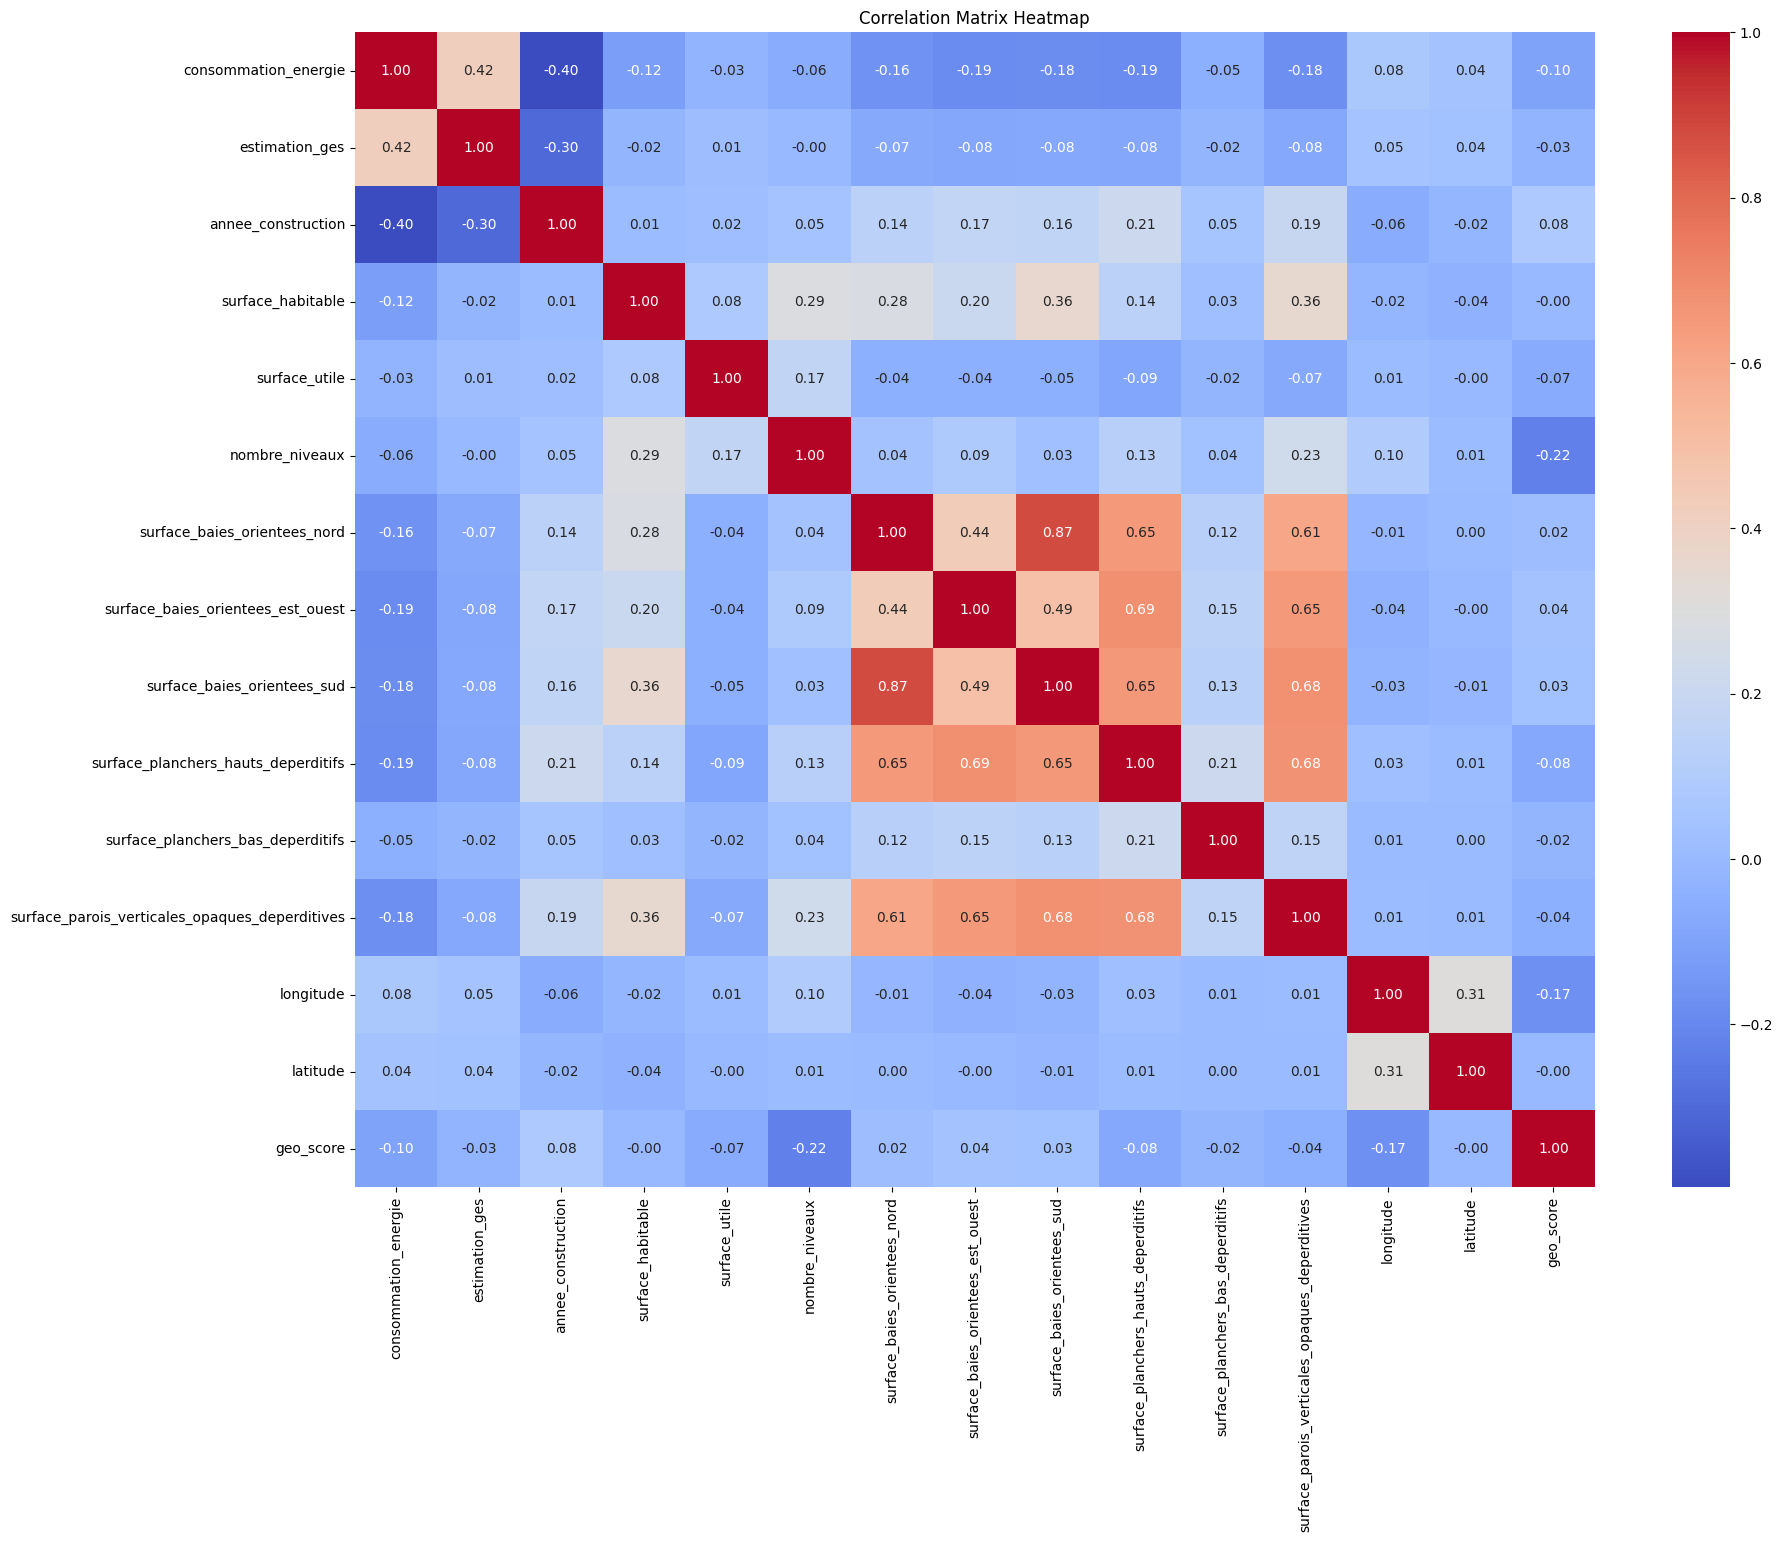

In [85]:
# Correlation matrix
corr_matrix = quantitative_df.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation greater than 0.67
high_corr_cols = [column for column in upper.columns if any(upper[column] > 0.67)]
print(f"Highly Correlated Columns: {high_corr_cols}")

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [86]:
# Drop highly correlated columns
quantitative_df = quantitative_df.drop(columns=high_corr_cols)
print(f"Qualitative df shape after dropping highly correlated columns: {quantitative_df.shape}")

Qualitative df shape after dropping highly correlated columns: (120490, 12)


In [87]:
quantitative_df

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00              1989.0   
1                     209.64            9.71              2001.0   
2                     177.12            5.77              1900.0   
3                     234.04           54.76              1900.0   
5                     278.63           13.89              1974.0   
...                      ...             ...                 ...   
125466                275.81           14.49              1982.0   
125467                151.22           35.38              1982.0   
125468                377.00           12.00              1947.0   
125469                273.00           16.00              1983.0   
125470                224.47            5.05              1900.0   

        surface_habitable  surface_utile  nombre_niveaux  \
0                   58.53            0.0             1.0   
1                  130.00          130.0             1.0   
2                   43.00            0.0             0.0   
3                   93.00           93.0             1.0   
5                  128.89            NaN             NaN   
...                   ...            ...             ...   
125466              79.00            NaN             NaN   
125467              98.00            NaN             NaN   
125468              32.05            0.0             1.0   
125469             174.00            0.0             1.0   
125470             150.50            0.0             0.0   

        surface_baies_orientees_nord  surface_baies_orientees_est_ouest  \
0                               5.26                                0.0   
1                               0.00                                0.0   
2                               0.00                                0.0   
3                               0.00                                0.0   
5                                NaN                                NaN   
...                              ...                                ...   
125466                           NaN                                NaN   
125467                           NaN                                NaN   
125468                          0.00                                0.0   
125469                          0.00                               19.9   
125470                          0.00                                0.0   

        surface_planchers_bas_deperditifs  longitude   latitude  geo_score  
0                                    0.00        NaN        NaN       0.00  
1                                    0.00   0.838555  47.539634       0.36  
2                                    0.00   0.696860  47.389350       0.98  
3                                    0.00        NaN        NaN       0.00  
5                                     NaN   0.713967  47.391239       0.96  
...                                   ...        ...        ...        ...  
125466                                NaN   0.624554  47.274189       0.96  
125467                                NaN   0.894629  47.594574       0.96  
125468                               0.00        NaN        NaN       0.00  
125469                             113.59   0.452953  47.024512       0.55  
125470                               0.00   0.282598  47.080600       0.32  

[120490 rows x 12 columns]

In [88]:
# manque d'information dans la colonne surface_utile par rapport à surface_habitable
# drop surface_utile 
quantitative_df = quantitative_df.drop(columns='surface_utile')

In [89]:
quantitative_df

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00              1989.0   
1                     209.64            9.71              2001.0   
2                     177.12            5.77              1900.0   
3                     234.04           54.76              1900.0   
5                     278.63           13.89              1974.0   
...                      ...             ...                 ...   
125466                275.81           14.49              1982.0   
125467                151.22           35.38              1982.0   
125468                377.00           12.00              1947.0   
125469                273.00           16.00              1983.0   
125470                224.47            5.05              1900.0   

        surface_habitable  nombre_niveaux  surface_baies_orientees_nord  \
0                   58.53             1.0                          5.26   
1                  130.00             1.0                          0.00   
2                   43.00             0.0                          0.00   
3                   93.00             1.0                          0.00   
5                  128.89             NaN                           NaN   
...                   ...             ...                           ...   
125466              79.00             NaN                           NaN   
125467              98.00             NaN                           NaN   
125468              32.05             1.0                          0.00   
125469             174.00             1.0                          0.00   
125470             150.50             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_planchers_bas_deperditifs  \
0                                     0.0                               0.00   
1                                     0.0                               0.00   
2                                     0.0                               0.00   
3                                     0.0                               0.00   
5                                     NaN                                NaN   
...                                   ...                                ...   
125466                                NaN                                NaN   
125467                                NaN                                NaN   
125468                                0.0                               0.00   
125469                               19.9                             113.59   
125470                                0.0                               0.00   

        longitude   latitude  geo_score  
0             NaN        NaN       0.00  
1        0.838555  47.539634       0.36  
2        0.696860  47.389350       0.98  
3             NaN        NaN       0.00  
5        0.713967  47.391239       0.96  
...           ...        ...        ...  
125466   0.624554  47.274189       0.96  
125467   0.894629  47.594574       0.96  
125468        NaN        NaN       0.00  
125469   0.452953  47.024512       0.55  
125470   0.282598  47.080600       0.32  

[120490 rows x 11 columns]

3. cramers correlation pour categorical df

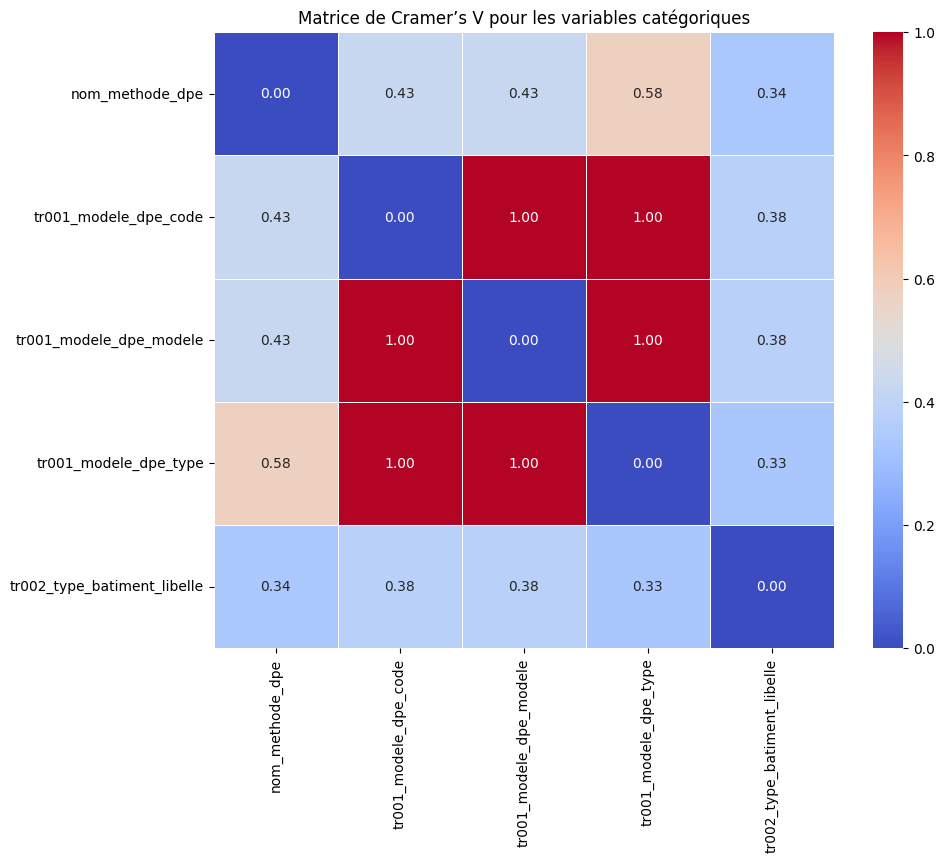

In [90]:
# Fonction pour calculer Cramer's V
categorical_columns = categorical_df.columns

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Matrice de Cramer’s V
n = len(categorical_columns)
cramers_matrix = pd.DataFrame(np.zeros((n, n)), columns=categorical_columns, index=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            confusion_matrix = pd.crosstab(categorical_df[col1], categorical_df[col2])
            cramers_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# Heatmap pour visualiser les corrélations
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matrice de Cramer’s V pour les variables catégoriques")
plt.show()

In [91]:
coll_rem = ['tr001_modele_dpe_code','tr001_modele_dpe_modele']

In [92]:
categorical_df = categorical_df.drop(columns=coll_rem)

In [93]:
categorical_df

nom_methode_dpe tr001_modele_dpe_type tr002_type_batiment_libelle
0           Méthode 3CL                 Vente                 Appartement
1          TROIS_CL_DPE                 Vente                      Maison
2             3CL - DPE              Location                 Appartement
3               FACTURE                 Vente                      Maison
5             3CL - DPE                 Vente                      Maison
...                 ...                   ...                         ...
125466        3CL - DPE                 Vente                      Maison
125467        3CL - DPE                 Vente                      Maison
125468  Méthode Facture              Location                 Appartement
125469      Méthode 3CL                 Vente                      Maison
125470        3CL - DPE                 Vente                      Maison

[120490 rows x 3 columns]

In [94]:
# Afficher toutes les valeurs uniques et leur fréquence pour la colonne 'nom_methode_dpe'
method_counts = categorical_df["nom_methode_dpe"].value_counts()

print(f"Unique Values for 'nom_methode_dpe': {method_counts}")

Unique Values for 'nom_methode_dpe': nom_methode_dpe
3CL - DPE                           43819
Méthode 3CL                         23156
FACTURE - DPE                       21237
Méthode Facture                     10388
TROIS_CL_DPE                         6782
3CL-DPE                              3966
FACTURE                              3632
Th-BCE                               1998
3CL                                  1276
facture                              1225
th-CE                                 894
TH_C_E                                445
Factures                              425
FACTURE SEULE                         421
TH_BCE                                342
Facture                               208
MIXTE FACTURE+3CL - DPE pour ECS      105
Neuf                                   94
Th-C-E                                 76
Facture - DPE                           1
Name: count, dtype: int64


In [95]:
# Dictionnaire de correspondance pour fusionner les valeurs similaires
correction_methode_dpe = {
    "3CL - DPE": "3CL - DPE",
    "3CL-DPE": "3CL - DPE",
    "TROIS_CL_DPE": "3CL - DPE",
    "3CL": "3CL - DPE",
    "Méthode 3CL": "3CL - DPE",
    
    "FACTURE - DPE": "Facture - DPE",
    "Méthode Facture": "Facture - DPE",
    "FACTURE": "Facture - DPE",
    "facture": "Facture - DPE",
    "Factures": "Facture - DPE",
    "FACTURE SEULE": "Facture - DPE",
    "Facture": "Facture - DPE",
    
    "TH_C_E": "Th-C-E",
    "th-CE": "Th-C-E",
    "Th-C-E": "Th-C-E",
    
    "TH_BCE": "Th-BCE",
    "th-BCE": "Th-BCE",
    
    "MIXTE FACTURE+3CL - DPE pour ECS": "ECS",
    "Neuf": "Neuf"
}

# Appliquer la correction sur la colonne nom_methode_dpe
categorical_df["nom_methode_dpe"] = categorical_df["nom_methode_dpe"].replace(correction_methode_dpe)

# Vérifier la correction des valeurs uniques
method_counts = categorical_df["nom_methode_dpe"].value_counts().reset_index()
method_counts.columns = ["nom_methode_dpe", "nombre_occurrences"]

In [96]:
# Afficher toutes les valeurs uniques et leur fréquence pour la colonne 'nom_methode_dpe' apres correction
method_counts = categorical_df["nom_methode_dpe"].value_counts()

print(f"Unique Values for 'nom_methode_dpe': {method_counts}")

Unique Values for 'nom_methode_dpe': nom_methode_dpe
3CL - DPE        78999
Facture - DPE    37537
Th-BCE            2340
Th-C-E            1415
ECS                105
Neuf                94
Name: count, dtype: int64


In [97]:
categorical_df

nom_methode_dpe tr001_modele_dpe_type tr002_type_batiment_libelle
0            3CL - DPE                 Vente                 Appartement
1            3CL - DPE                 Vente                      Maison
2            3CL - DPE              Location                 Appartement
3        Facture - DPE                 Vente                      Maison
5            3CL - DPE                 Vente                      Maison
...                ...                   ...                         ...
125466       3CL - DPE                 Vente                      Maison
125467       3CL - DPE                 Vente                      Maison
125468   Facture - DPE              Location                 Appartement
125469       3CL - DPE                 Vente                      Maison
125470       3CL - DPE                 Vente                      Maison

[120490 rows x 3 columns]

In [98]:
merged_df = pd.concat([quantitative_df, qualitative_df, categorical_df], axis=1)

In [99]:
# Change the data type of 'annee_construction' to int
merged_df['annee_construction'] = merged_df['annee_construction'].astype(int)

In [100]:
classification, classification_df, quantitative_df, qualitative_df, categorical_df = classify_columns(merged_df)

In [101]:
quantitative_df

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00                1989   
1                     209.64            9.71                2001   
2                     177.12            5.77                1900   
3                     234.04           54.76                1900   
5                     278.63           13.89                1974   
...                      ...             ...                 ...   
125466                275.81           14.49                1982   
125467                151.22           35.38                1982   
125468                377.00           12.00                1947   
125469                273.00           16.00                1983   
125470                224.47            5.05                1900   

        surface_habitable  nombre_niveaux  surface_baies_orientees_nord  \
0                   58.53             1.0                          5.26   
1                  130.00             1.0                          0.00   
2                   43.00             0.0                          0.00   
3                   93.00             1.0                          0.00   
5                  128.89             NaN                           NaN   
...                   ...             ...                           ...   
125466              79.00             NaN                           NaN   
125467              98.00             NaN                           NaN   
125468              32.05             1.0                          0.00   
125469             174.00             1.0                          0.00   
125470             150.50             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_planchers_bas_deperditifs  \
0                                     0.0                               0.00   
1                                     0.0                               0.00   
2                                     0.0                               0.00   
3                                     0.0                               0.00   
5                                     NaN                                NaN   
...                                   ...                                ...   
125466                                NaN                                NaN   
125467                                NaN                                NaN   
125468                                0.0                               0.00   
125469                               19.9                             113.59   
125470                                0.0                               0.00   

        longitude   latitude  geo_score  
0             NaN        NaN       0.00  
1        0.838555  47.539634       0.36  
2        0.696860  47.389350       0.98  
3             NaN        NaN       0.00  
5        0.713967  47.391239       0.96  
...           ...        ...        ...  
125466   0.624554  47.274189       0.96  
125467   0.894629  47.594574       0.96  
125468        NaN        NaN       0.00  
125469   0.452953  47.024512       0.55  
125470   0.282598  47.080600       0.32  

[120490 rows x 11 columns]

In [102]:
qualitative_df

tr002_type_batiment_ordre
0                               2
1                               1
2                               2
3                               1
5                               1
...                           ...
125466                          1
125467                          1
125468                          2
125469                          1
125470                          1

[120490 rows x 1 columns]

In [103]:
# Détecter les colonnes avec des valeurs nulles
null_columns = quantitative_df.isnull().sum()

# Filtrer les colonnes qui contiennent des valeurs nulles
columns_with_nulls = null_columns[null_columns > 0]

# Afficher les colonnes avec des valeurs nulles et leur nombre
print("Colonnes avec des valeurs nulles :")
print(columns_with_nulls)

Colonnes avec des valeurs nulles :
nombre_niveaux                       33628
surface_baies_orientees_nord         34885
surface_baies_orientees_est_ouest    34885
surface_planchers_bas_deperditifs    34885
longitude                            13128
latitude                             13128
dtype: int64


# Correlation avec la variable cible

### Quantitative with pearson

In [104]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def compute_correlations(df, target_variable):
    """
    Computes the correlation between each column in a DataFrame and the target variable,
    considering only the available values for each column and reporting the percentage of available data.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the target variable.
        target_variable (str): The column name of the target variable.

    Returns:
        pd.DataFrame: A DataFrame with columns ['Feature', 'Correlation', 'P-Value', 'Data_Availability'].
    """
    if target_variable not in df.columns:
        raise ValueError(f"Target variable '{target_variable}' is not in the DataFrame.")

    correlations = []
    for column in df.columns:
        if column == target_variable:
            continue

        # Filter out rows where either the column or target variable is NaN
        valid_data = df[[column, target_variable]].dropna()

        # Compute the percentage of available data
        availability = len(valid_data) / len(df) * 100
        # gard number of valid data / len(df) as string in columns
        
         
        if np.issubdtype(df[column].dtype, np.number):  # Numeric column
            try:
                corr, p_value = pearsonr(valid_data[column], valid_data[target_variable])
            except Exception as e:
                corr, p_value = np.nan, np.nan  # Handle cases where correlation can't be computed
        else:  # Non-numeric column
            corr, p_value = np.nan, np.nan  # Extend with categorical correlation techniques if needed

        correlations.append({'Feature': column, 'Correlation': corr, 'P-Value': p_value, 'Data_Availability': availability})

    # Convert to DataFrame
    correlation_df = pd.DataFrame(correlations)
    correlation_df.sort_values(by='Correlation', ascending=False, inplace=True)

    return correlation_df

# Utilisation
correlation_numeric = compute_correlations(quantitative_df, 'consommation_energie')

In [105]:
correlation_numeric

Feature  Correlation        P-Value  \
0                     estimation_ges     0.420590   0.000000e+00   
7                          longitude     0.076069  1.636454e-137   
8                           latitude     0.040729   1.174444e-40   
6  surface_planchers_bas_deperditifs    -0.051221   7.808268e-51   
3                     nombre_niveaux    -0.063793   5.161161e-79   
9                          geo_score    -0.097788  9.493460e-254   
2                  surface_habitable    -0.117403   0.000000e+00   
4       surface_baies_orientees_nord    -0.158996   0.000000e+00   
5  surface_baies_orientees_est_ouest    -0.188733   0.000000e+00   
1                 annee_construction    -0.397159   0.000000e+00   

   Data_Availability  
0          100.00000  
7           89.10449  
8           89.10449  
6           71.04739  
3           72.09063  
9          100.00000  
2          100.00000  
4           71.04739  
5           71.04739  
1          100.00000

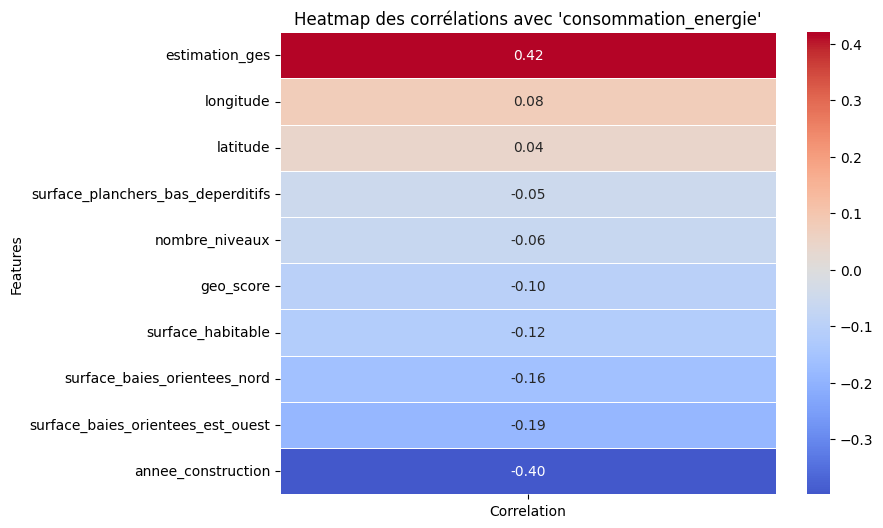

In [106]:
# Correction de la heatmap en utilisant les bonnes colonnes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_numeric.set_index('Feature')[['Correlation']], 
            annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)

plt.title("Heatmap des corrélations avec 'consommation_energie'")
plt.ylabel("Features")
plt.show()

### Categoriel

In [107]:
def compute_categorical_correlations(df, numeric_series):
    """
    Computes the correlation between each categorical column in the DataFrame
    and the target numeric series using appropriate statistical tests.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing categorical columns.
        numeric_series (pd.Series): The numeric series to test correlation against.

    Returns:
        pd.DataFrame: A DataFrame with columns ['Feature', 'Correlation Type', 'Statistic', 'P-Value'].
    """
    if len(df) != len(numeric_series):
        raise ValueError("The length of the numeric series must match the number of rows in the DataFrame.")

    correlations = []

    for column in df.columns:
        if df[column].dtype == 'object' or np.issubdtype(df[column].dtype, np.integer):
            # If the column is categorical
            if df[column].nunique() > 2:  # Multi-class categorical variable
                # Use ANOVA for multi-class categorical vs numeric
                groups = [numeric_series[df[column] == category] for category in df[column].unique()]
                try:
                    stat, p_value = f_oneway(*groups)
                    correlation_type = 'ANOVA'
                except Exception as e:
                    stat, p_value, correlation_type = np.nan, np.nan, 'ANOVA Failed'
            else:  # Binary categorical variable
                # Use Chi-squared test for binary categorical vs numeric
                contingency_table = pd.crosstab(df[column], numeric_series.round())
                try:
                    stat, p_value, _, _ = chi2_contingency(contingency_table)
                    correlation_type = 'Chi-Squared'
                except Exception as e:
                    stat, p_value, correlation_type = np.nan, np.nan, 'Chi-Squared Failed'

            correlations.append({
                'Feature': column,
                'Correlation Type': correlation_type,
                'Statistic': stat,
                'P-Value': p_value
            })

    correlation_df = pd.DataFrame(correlations)
    correlation_df.sort_values(by='P-Value', ascending=True, inplace=True)

    return correlation_df

In [108]:
# categorical_df
compute_categorical_correlations(categorical_df, quantitative_df['consommation_energie'])

Feature Correlation Type     Statistic  P-Value
0              nom_methode_dpe            ANOVA   3967.008024      0.0
1        tr001_modele_dpe_type            ANOVA  16052.626270      0.0
2  tr002_type_batiment_libelle            ANOVA   2441.799907      0.0

In [109]:
# qualitative_df
compute_categorical_correlations(qualitative_df, quantitative_df['consommation_energie'])

Feature Correlation Type    Statistic  P-Value
0  tr002_type_batiment_ordre            ANOVA  2441.799907      0.0

In [110]:
# the statistic for tr002_type_batiment_ordre similar to tr002_type_batiment_libelle 
# we have to drop one of them
# drop tr002_type_batiment_ordre

In [111]:
# take just quantitative and categorical columns, 
# at qualitative_df we have only one column that we have dropped
merged_data = pd.concat([quantitative_df,categorical_df], axis=1)

In [112]:
merged_data

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00                1989   
1                     209.64            9.71                2001   
2                     177.12            5.77                1900   
3                     234.04           54.76                1900   
5                     278.63           13.89                1974   
...                      ...             ...                 ...   
125466                275.81           14.49                1982   
125467                151.22           35.38                1982   
125468                377.00           12.00                1947   
125469                273.00           16.00                1983   
125470                224.47            5.05                1900   

        surface_habitable  nombre_niveaux  surface_baies_orientees_nord  \
0                   58.53             1.0                          5.26   
1                  130.00             1.0                          0.00   
2                   43.00             0.0                          0.00   
3                   93.00             1.0                          0.00   
5                  128.89             NaN                           NaN   
...                   ...             ...                           ...   
125466              79.00             NaN                           NaN   
125467              98.00             NaN                           NaN   
125468              32.05             1.0                          0.00   
125469             174.00             1.0                          0.00   
125470             150.50             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_planchers_bas_deperditifs  \
0                                     0.0                               0.00   
1                                     0.0                               0.00   
2                                     0.0                               0.00   
3                                     0.0                               0.00   
5                                     NaN                                NaN   
...                                   ...                                ...   
125466                                NaN                                NaN   
125467                                NaN                                NaN   
125468                                0.0                               0.00   
125469                               19.9                             113.59   
125470                                0.0                               0.00   

        longitude   latitude  geo_score nom_methode_dpe tr001_modele_dpe_type  \
0             NaN        NaN       0.00       3CL - DPE                 Vente   
1        0.838555  47.539634       0.36       3CL - DPE                 Vente   
2        0.696860  47.389350       0.98       3CL - DPE              Location   
3             NaN        NaN       0.00   Facture - DPE                 Vente   
5        0.713967  47.391239       0.96       3CL - DPE                 Vente   
...           ...        ...        ...             ...                   ...   
125466   0.624554  47.274189       0.96       3CL - DPE                 Vente   
125467   0.894629  47.594574       0.96       3CL - DPE                 Vente   
125468        NaN        NaN       0.00   Facture - DPE              Location   
125469   0.452953  47.024512       0.55       3CL - DPE                 Vente   
125470   0.282598  47.080600       0.32       3CL - DPE                 Vente   

       tr002_type_batiment_libelle  
0                      Appartement  
1                           Maison  
2                      Appartement  
3                           Maison  
5                           Maison  
...                            ...  
125466                      Maison  
125467                      Maison  
125468                 

In [113]:
classification, classification_df, quantitative_df, qualitative_df, categorical_df = classify_columns(merged_data)

In [114]:
quantitative_df

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00                1989   
1                     209.64            9.71                2001   
2                     177.12            5.77                1900   
3                     234.04           54.76                1900   
5                     278.63           13.89                1974   
...                      ...             ...                 ...   
125466                275.81           14.49                1982   
125467                151.22           35.38                1982   
125468                377.00           12.00                1947   
125469                273.00           16.00                1983   
125470                224.47            5.05                1900   

        surface_habitable  nombre_niveaux  surface_baies_orientees_nord  \
0                   58.53             1.0                          5.26   
1                  130.00             1.0                          0.00   
2                   43.00             0.0                          0.00   
3                   93.00             1.0                          0.00   
5                  128.89             NaN                           NaN   
...                   ...             ...                           ...   
125466              79.00             NaN                           NaN   
125467              98.00             NaN                           NaN   
125468              32.05             1.0                          0.00   
125469             174.00             1.0                          0.00   
125470             150.50             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_planchers_bas_deperditifs  \
0                                     0.0                               0.00   
1                                     0.0                               0.00   
2                                     0.0                               0.00   
3                                     0.0                               0.00   
5                                     NaN                                NaN   
...                                   ...                                ...   
125466                                NaN                                NaN   
125467                                NaN                                NaN   
125468                                0.0                               0.00   
125469                               19.9                             113.59   
125470                                0.0                               0.00   

        longitude   latitude  geo_score  
0             NaN        NaN       0.00  
1        0.838555  47.539634       0.36  
2        0.696860  47.389350       0.98  
3             NaN        NaN       0.00  
5        0.713967  47.391239       0.96  
...           ...        ...        ...  
125466   0.624554  47.274189       0.96  
125467   0.894629  47.594574       0.96  
125468        NaN        NaN       0.00  
125469   0.452953  47.024512       0.55  
125470   0.282598  47.080600       0.32  

[120490 rows x 11 columns]

In [115]:
categorical_df

nom_methode_dpe tr001_modele_dpe_type tr002_type_batiment_libelle
0            3CL - DPE                 Vente                 Appartement
1            3CL - DPE                 Vente                      Maison
2            3CL - DPE              Location                 Appartement
3        Facture - DPE                 Vente                      Maison
5            3CL - DPE                 Vente                      Maison
...                ...                   ...                         ...
125466       3CL - DPE                 Vente                      Maison
125467       3CL - DPE                 Vente                      Maison
125468   Facture - DPE              Location                 Appartement
125469       3CL - DPE                 Vente                      Maison
125470       3CL - DPE                 Vente                      Maison

[120490 rows x 3 columns]

# Imputation

In [116]:
# voir correlation pour surface_planchers_bas_deperditifs
correlation_numeric = compute_correlations(quantitative_df, 'surface_planchers_bas_deperditifs')

# choisir les colonnes qui ont une correlation significative

In [117]:
correlation_numeric

Feature  Correlation        P-Value  \
6  surface_baies_orientees_est_ouest     0.146086   0.000000e+00   
5       surface_baies_orientees_nord     0.123963  3.010178e-290   
2                 annee_construction     0.054636   1.334840e-57   
4                     nombre_niveaux     0.036149   3.693371e-26   
3                  surface_habitable     0.025730   5.103596e-14   
7                          longitude     0.006319   8.883823e-02   
8                           latitude     0.001839   6.205600e-01   
9                          geo_score    -0.021132   6.266556e-10   
1                     estimation_ges    -0.021675   2.260053e-10   
0               consommation_energie    -0.051221   7.808268e-51   

   Data_Availability  
6          71.047390  
5          71.047390  
2          71.047390  
4          71.047390  
3          71.047390  
7          60.177608  
8          60.177608  
9          71.047390  
1          71.047390  
0          71.047390

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# imputation de surface_planchers_bas_deperditifs aevec regression linéaire
df = quantitative_df.copy()

# Séparer les lignes avec et sans valeurs manquantes
df_not_null = df[df["surface_planchers_bas_deperditifs"].notnull()]
df_null = df[df["surface_planchers_bas_deperditifs"].isnull()]

columns=['surface_baies_orientees_est_ouest','surface_baies_orientees_nord']


X_train = df_not_null[columns]
y_train = df_not_null["surface_planchers_bas_deperditifs"]

X_missing = df_null[columns]  # Lignes où la cible est manquante

# Imputer les valeurs manquantes des features (ex : médiane)
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=('surface_baies_orientees_est_ouest','surface_baies_orientees_nord'))
X_missing = pd.DataFrame(imputer.transform(X_missing), columns=('surface_baies_orientees_est_ouest','surface_baies_orientees_nord'))

# Initialiser et entraîner le modèle de régression linéaire
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Prédire les valeurs manquantes
predictions = reg_model.predict(X_missing)

# Remplacer les valeurs nulles par les prédictions
df.loc[df["surface_planchers_bas_deperditifs"].isnull(), "surface_planchers_bas_deperditifs"] = predictions

print("✅ Imputation terminée avec une régression linéaire.")

✅ Imputation terminée avec une régression linéaire.


In [119]:
# Détecter les colonnes avec des valeurs nulles
null_columns = df.isnull().sum()

# Filtrer les colonnes qui contiennent des valeurs nulles
columns_with_nulls = null_columns[null_columns > 0]

# Afficher les colonnes avec des valeurs nulles et leur nombre
print("Colonnes avec des valeurs nulles :")
print(columns_with_nulls)

Colonnes avec des valeurs nulles :
nombre_niveaux                       33628
surface_baies_orientees_nord         34885
surface_baies_orientees_est_ouest    34885
longitude                            13128
latitude                             13128
dtype: int64


In [120]:
df

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00                1989   
1                     209.64            9.71                2001   
2                     177.12            5.77                1900   
3                     234.04           54.76                1900   
5                     278.63           13.89                1974   
...                      ...             ...                 ...   
125466                275.81           14.49                1982   
125467                151.22           35.38                1982   
125468                377.00           12.00                1947   
125469                273.00           16.00                1983   
125470                224.47            5.05                1900   

        surface_habitable  nombre_niveaux  surface_baies_orientees_nord  \
0                   58.53             1.0                          5.26   
1                  130.00             1.0                          0.00   
2                   43.00             0.0                          0.00   
3                   93.00             1.0                          0.00   
5                  128.89             NaN                           NaN   
...                   ...             ...                           ...   
125466              79.00             NaN                           NaN   
125467              98.00             NaN                           NaN   
125468              32.05             1.0                          0.00   
125469             174.00             1.0                          0.00   
125470             150.50             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_planchers_bas_deperditifs  \
0                                     0.0                           0.000000   
1                                     0.0                           0.000000   
2                                     0.0                           0.000000   
3                                     0.0                           0.000000   
5                                     NaN                          26.009948   
...                                   ...                                ...   
125466                                NaN                          26.009948   
125467                                NaN                          26.009948   
125468                                0.0                           0.000000   
125469                               19.9                         113.590000   
125470                                0.0                           0.000000   

        longitude   latitude  geo_score  
0             NaN        NaN       0.00  
1        0.838555  47.539634       0.36  
2        0.696860  47.389350       0.98  
3             NaN        NaN       0.00  
5        0.713967  47.391239       0.96  
...           ...        ...        ...  
125466   0.624554  47.274189       0.96  
125467   0.894629  47.594574       0.96  
125468        NaN        NaN       0.00  
125469   0.452953  47.024512       0.55  
125470   0.282598  47.080600       0.32  

[120490 rows x 11 columns]

In [121]:
from sklearn.impute import KNNImputer

# 1. Médiane pour les valeurs continues
median_imputer = SimpleImputer(strategy="median")
#quantitative_df[["surface_planchers_bas_deperditifs"]] = median_imputer.fit_transform(df_cleaned[["surface_planchers_bas_deperditifs"]])

# 2. Mode (valeur la plus fréquente) pour les valeurs discrètes
mode_imputer = SimpleImputer(strategy="most_frequent")
df[["nombre_niveaux"]] = mode_imputer.fit_transform(df[["nombre_niveaux"]])

# 3. Valeur 0 pour les surfaces des baies vitrées si elles sont souvent nulles
if (df[["surface_baies_orientees_nord", "surface_baies_orientees_est_ouest"]] == 0).sum().sum() > len(df) * 0.5:
    df[["surface_baies_orientees_nord", "surface_baies_orientees_est_ouest"]] = df[["surface_baies_orientees_nord", "surface_baies_orientees_est_ouest"]].fillna(0)
else:
    df[["surface_baies_orientees_nord", "surface_baies_orientees_est_ouest"]] = median_imputer.fit_transform(df[["surface_baies_orientees_nord", "surface_baies_orientees_est_ouest"]])

# 4. KNN Imputer pour les coordonnées géographiques (longitude, latitude, geo_score)
knn_imputer = KNNImputer(n_neighbors=3)
df[["longitude", "latitude"]] = knn_imputer.fit_transform(df[["longitude", "latitude"]])

In [122]:
# Détecter les colonnes avec des valeurs nulles
null_columns = df.isnull().sum()

# Filtrer les colonnes qui contiennent des valeurs nulles
columns_with_nulls = null_columns[null_columns > 0]

# Afficher les colonnes avec des valeurs nulles et leur nombre
print("Colonnes avec des valeurs nulles :")
print(columns_with_nulls)

Colonnes avec des valeurs nulles :
Series([], dtype: int64)


In [123]:
df

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00                1989   
1                     209.64            9.71                2001   
2                     177.12            5.77                1900   
3                     234.04           54.76                1900   
5                     278.63           13.89                1974   
...                      ...             ...                 ...   
125466                275.81           14.49                1982   
125467                151.22           35.38                1982   
125468                377.00           12.00                1947   
125469                273.00           16.00                1983   
125470                224.47            5.05                1900   

        surface_habitable  nombre_niveaux  surface_baies_orientees_nord  \
0                   58.53             1.0                          5.26   
1                  130.00             1.0                          0.00   
2                   43.00             0.0                          0.00   
3                   93.00             1.0                          0.00   
5                  128.89             0.0                          0.00   
...                   ...             ...                           ...   
125466              79.00             0.0                          0.00   
125467              98.00             0.0                          0.00   
125468              32.05             1.0                          0.00   
125469             174.00             1.0                          0.00   
125470             150.50             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_planchers_bas_deperditifs  \
0                                     0.0                           0.000000   
1                                     0.0                           0.000000   
2                                     0.0                           0.000000   
3                                     0.0                           0.000000   
5                                     0.0                          26.009948   
...                                   ...                                ...   
125466                                0.0                          26.009948   
125467                                0.0                          26.009948   
125468                                0.0                           0.000000   
125469                               19.9                         113.590000   
125470                                0.0                           0.000000   

        longitude   latitude  geo_score  
0        0.874818  47.411432       0.00  
1        0.838555  47.539634       0.36  
2        0.696860  47.389350       0.98  
3        0.874818  47.411432       0.00  
5        0.713967  47.391239       0.96  
...           ...        ...        ...  
125466   0.624554  47.274189       0.96  
125467   0.894629  47.594574       0.96  
125468   0.874818  47.411432       0.00  
125469   0.452953  47.024512       0.55  
125470   0.282598  47.080600       0.32  

[120490 rows x 11 columns]

### remove outliers

In [124]:
merged_data = pd.concat([df,categorical_df], axis=1)

In [125]:
merged_data.to_csv("train_test_set_cleaned_to_normalise.csv", index=False)

# Normalisation

### Normalisation quantitative

In [126]:
merged_data

consommation_energie  estimation_ges  annee_construction  \
0                     201.00            8.00                1989   
1                     209.64            9.71                2001   
2                     177.12            5.77                1900   
3                     234.04           54.76                1900   
5                     278.63           13.89                1974   
...                      ...             ...                 ...   
125466                275.81           14.49                1982   
125467                151.22           35.38                1982   
125468                377.00           12.00                1947   
125469                273.00           16.00                1983   
125470                224.47            5.05                1900   

        surface_habitable  nombre_niveaux  surface_baies_orientees_nord  \
0                   58.53             1.0                          5.26   
1                  130.00             1.0                          0.00   
2                   43.00             0.0                          0.00   
3                   93.00             1.0                          0.00   
5                  128.89             0.0                          0.00   
...                   ...             ...                           ...   
125466              79.00             0.0                          0.00   
125467              98.00             0.0                          0.00   
125468              32.05             1.0                          0.00   
125469             174.00             1.0                          0.00   
125470             150.50             0.0                          0.00   

        surface_baies_orientees_est_ouest  surface_planchers_bas_deperditifs  \
0                                     0.0                           0.000000   
1                                     0.0                           0.000000   
2                                     0.0                           0.000000   
3                                     0.0                           0.000000   
5                                     0.0                          26.009948   
...                                   ...                                ...   
125466                                0.0                          26.009948   
125467                                0.0                          26.009948   
125468                                0.0                           0.000000   
125469                               19.9                         113.590000   
125470                                0.0                           0.000000   

        longitude   latitude  geo_score nom_methode_dpe tr001_modele_dpe_type  \
0        0.874818  47.411432       0.00       3CL - DPE                 Vente   
1        0.838555  47.539634       0.36       3CL - DPE                 Vente   
2        0.696860  47.389350       0.98       3CL - DPE              Location   
3        0.874818  47.411432       0.00   Facture - DPE                 Vente   
5        0.713967  47.391239       0.96       3CL - DPE                 Vente   
...           ...        ...        ...             ...                   ...   
125466   0.624554  47.274189       0.96       3CL - DPE                 Vente   
125467   0.894629  47.594574       0.96       3CL - DPE                 Vente   
125468   0.874818  47.411432       0.00   Facture - DPE              Location   
125469   0.452953  47.024512       0.55       3CL - DPE                 Vente   
125470   0.282598  47.080600       0.32       3CL - DPE                 Vente   

       tr002_type_batiment_libelle  
0                      Appartement  
1                           Maison  
2                      Appartement  
3                           Maison  
5                           Maison  
...                            ...  
125466                      Maison  
125467                      Maison  
125468                 

In [127]:
classification, classification_df, quantitative_df, qualitative_df, categorical_df = classify_columns(merged_data)

### supprimer le outliers avec IQ avant da passer a la normalisation 

In [128]:
import pandas as pd

def remove_outliers_iqr(df, columns):
    """
    Supprime les outliers d'un DataFrame en utilisant la méthode IQR.
    Ne touche pas la colonne 'annee_construction'.

    Parameters:
        df (pd.DataFrame): Le DataFrame d'entrée.
        columns (list): Liste des colonnes à nettoyer.

    Returns:
        pd.DataFrame: Le DataFrame avec les outliers supprimés.
    """
    # Exclure 'annee_construction' si elle est présente
    cols_to_check = [col for col in columns if col != "annee_construction"]

    if not cols_to_check:  # Si après exclusion, il ne reste plus de colonnes à traiter
        print("⚠️ Aucune colonne quantitative à traiter après exclusion de 'annee_construction'.")
        return df

    # Calcul des quartiles et de l'IQR
    Q1 = df[cols_to_check].quantile(0.25)
    Q3 = df[cols_to_check].quantile(0.75)
    IQR = Q3 - Q1

    # Définition des bornes des outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrage des outliers (sans toucher 'annee_construction')
    df_cleaned = df[((df[cols_to_check] >= lower_bound) & (df[cols_to_check] <= upper_bound)).all(axis=1)]

    return df_cleaned

In [129]:
df_cleaned = remove_outliers_iqr(merged_data, quantitative_df.columns)

In [130]:
df_cleaned

consommation_energie  estimation_ges  annee_construction  \
2                     177.12            5.77                1900   
3                     234.04           54.76                1900   
5                     278.63           13.89                1974   
7                     361.30           65.00                1960   
10                    202.15           47.30                1970   
...                      ...             ...                 ...   
125460                138.05           32.30                1940   
125461                218.35           35.68                1955   
125463                109.50           25.62                1990   
125466                275.81           14.49                1982   
125468                377.00           12.00                1947   

        surface_habitable  nombre_niveaux  surface_baies_orientees_nord  \
2                   43.00             0.0                           0.0   
3                   93.00             1.0                           0.0   
5                  128.89             0.0                           0.0   
7                   71.00             1.0                           0.0   
10                  68.80             0.0                           0.0   
...                   ...             ...                           ...   
125460             104.86             1.0                           0.0   
125461             102.00             1.0                           0.0   
125463             147.00             1.0                           0.0   
125466              79.00             0.0                           0.0   
125468              32.05             1.0                           0.0   

        surface_baies_orientees_est_ouest  surface_planchers_bas_deperditifs  \
2                                     0.0                           0.000000   
3                                     0.0                           0.000000   
5                                     0.0                          26.009948   
7                                     0.0                           0.000000   
10                                    0.0                           0.000000   
...                                   ...                                ...   
125460                                0.0                           0.000000   
125461                                0.0                           0.000000   
125463                                0.0                           0.000000   
125466                                0.0                          26.009948   
125468                                0.0                           0.000000   

        longitude   latitude  geo_score nom_methode_dpe tr001_modele_dpe_type  \
2        0.696860  47.389350       0.98       3CL - DPE              Location   
3        0.874818  47.411432       0.00   Facture - DPE                 Vente   
5        0.713967  47.391239       0.96       3CL - DPE                 Vente   
7        0.671289  47.410345       0.66       3CL - DPE                 Vente   
10       0.691473  47.383139       0.98       3CL - DPE              Location   
...           ...        ...        ...             ...                   ...   
125460   0.677181  47.388400       0.98   Facture - DPE                 Vente   
125461   0.694108  47.358978       0.86       3CL - DPE                 Vente   
125463   0.594073  47.273675       0.44       3CL - DPE                 Vente   
125466   0.624554  47.274189       0.96       3CL - DPE                 Vente   
125468   0.874818  47.411432       0.00   Facture - DPE              Location   

       tr002_type_batiment_libelle  
2                      Appartement  
3                           Maison  
5                           Maison  
7                           Maison  
10                     Appartement  
...                            ...  
125460                 Appartement  
125461                      Maison  
125463                 

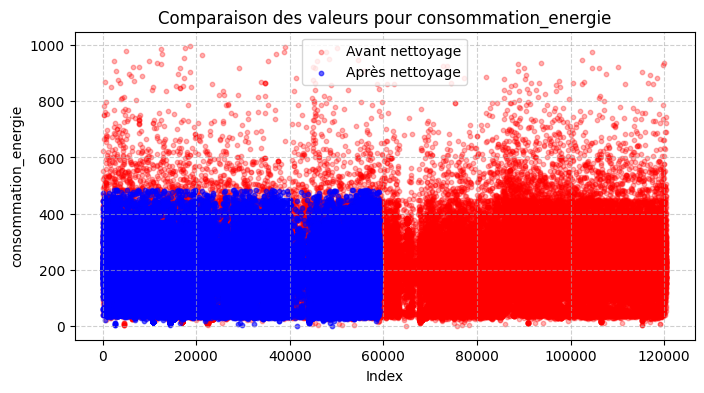

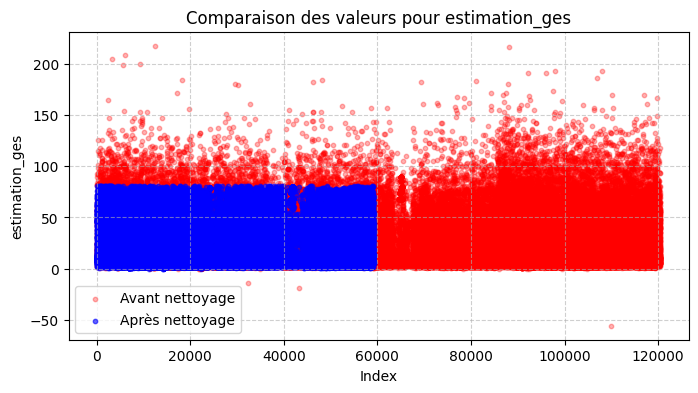

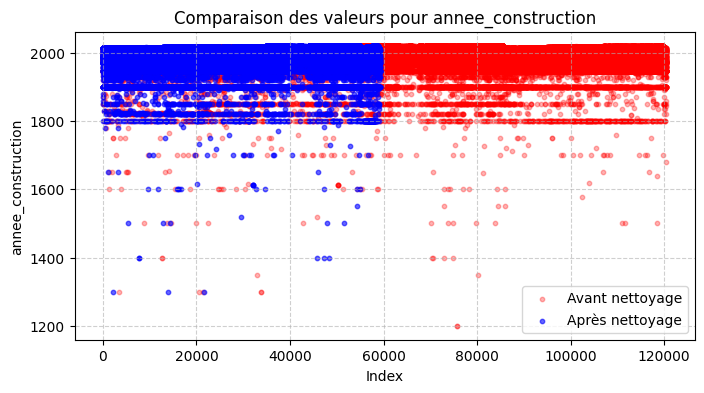

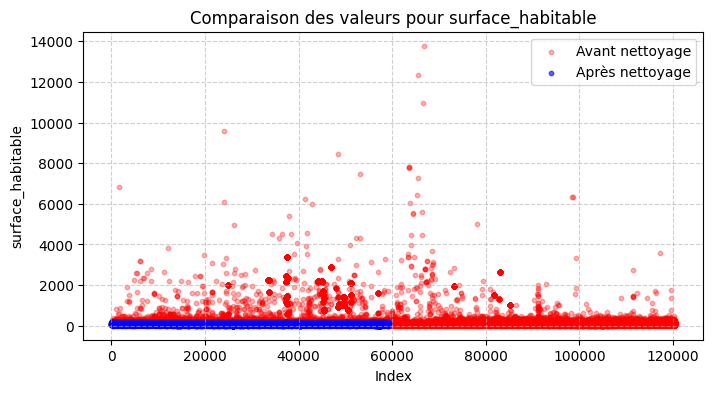

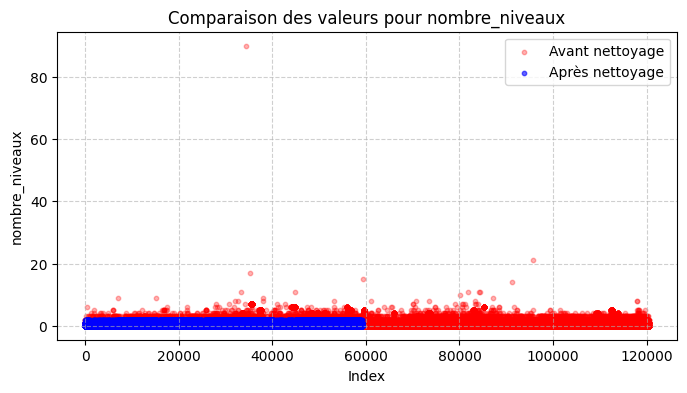

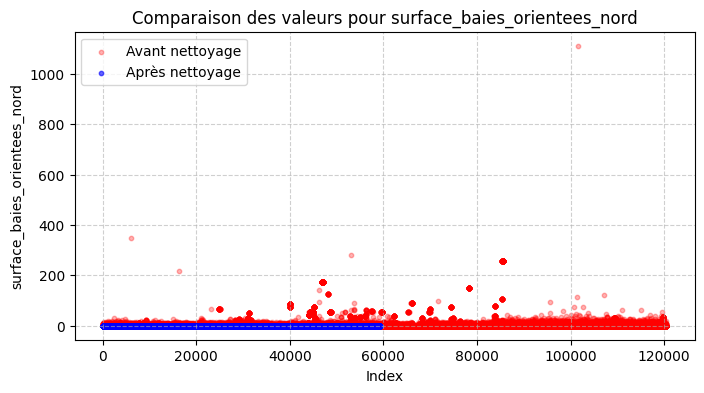

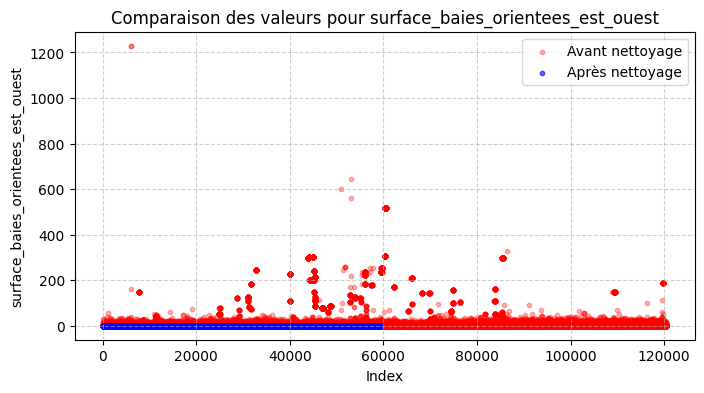

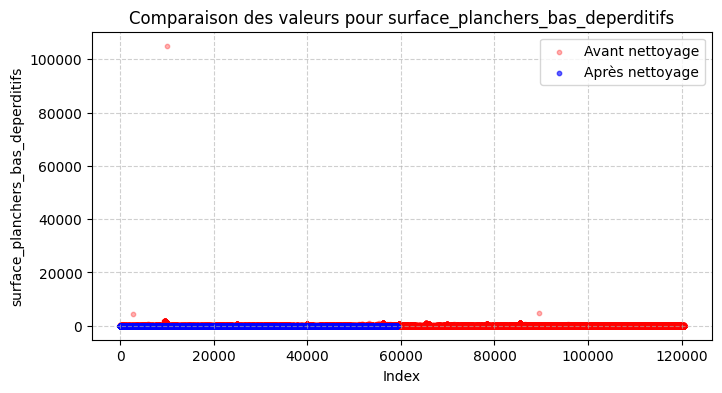

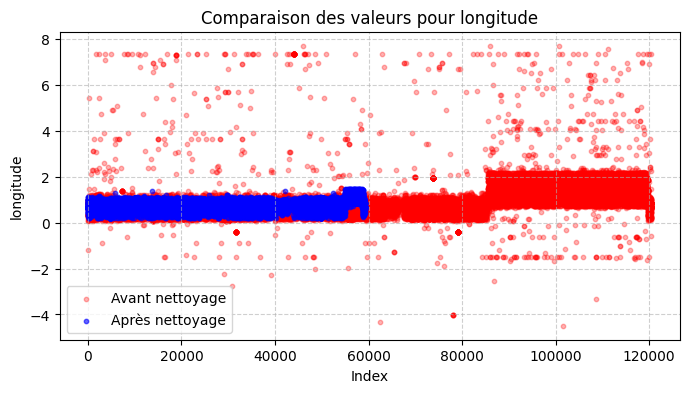

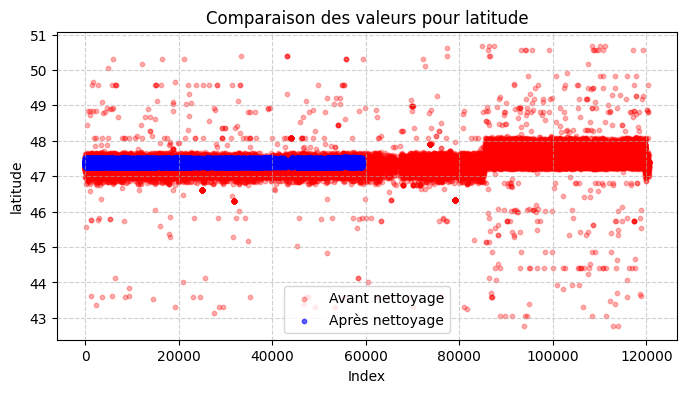

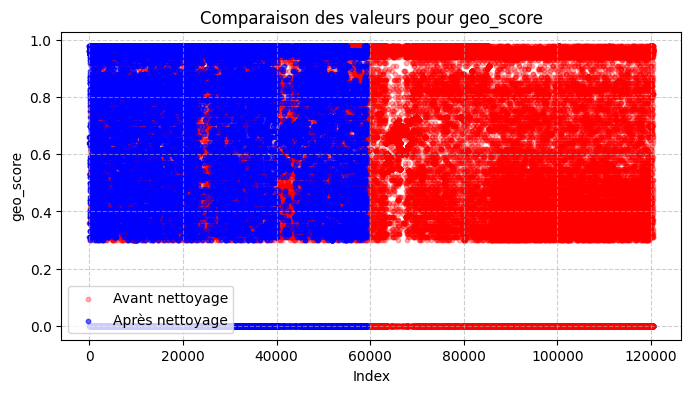

In [131]:
import matplotlib.pyplot as plt

# Scatter plot pour comparer les données avant/après suppression des outliers
for column in quantitative_df.columns:
    plt.figure(figsize=(8, 4))

    # Affichage des valeurs avant suppression des outliers
    plt.scatter(range(len(quantitative_df[column])), quantitative_df[column], alpha=0.3, s=10, color='red', label="Avant nettoyage")

    # Affichage des valeurs après suppression des outliers
    plt.scatter(range(len(df_cleaned[column])), df_cleaned[column], alpha=0.6, s=10, color='blue', label="Après nettoyage")

    # Ajout de titre et labels
    plt.title(f"Comparaison des valeurs pour {column}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()


In [132]:
df_cleaned

consommation_energie  estimation_ges  annee_construction  \
2                     177.12            5.77                1900   
3                     234.04           54.76                1900   
5                     278.63           13.89                1974   
7                     361.30           65.00                1960   
10                    202.15           47.30                1970   
...                      ...             ...                 ...   
125460                138.05           32.30                1940   
125461                218.35           35.68                1955   
125463                109.50           25.62                1990   
125466                275.81           14.49                1982   
125468                377.00           12.00                1947   

        surface_habitable  nombre_niveaux  surface_baies_orientees_nord  \
2                   43.00             0.0                           0.0   
3                   93.00             1.0                           0.0   
5                  128.89             0.0                           0.0   
7                   71.00             1.0                           0.0   
10                  68.80             0.0                           0.0   
...                   ...             ...                           ...   
125460             104.86             1.0                           0.0   
125461             102.00             1.0                           0.0   
125463             147.00             1.0                           0.0   
125466              79.00             0.0                           0.0   
125468              32.05             1.0                           0.0   

        surface_baies_orientees_est_ouest  surface_planchers_bas_deperditifs  \
2                                     0.0                           0.000000   
3                                     0.0                           0.000000   
5                                     0.0                          26.009948   
7                                     0.0                           0.000000   
10                                    0.0                           0.000000   
...                                   ...                                ...   
125460                                0.0                           0.000000   
125461                                0.0                           0.000000   
125463                                0.0                           0.000000   
125466                                0.0                          26.009948   
125468                                0.0                           0.000000   

        longitude   latitude  geo_score nom_methode_dpe tr001_modele_dpe_type  \
2        0.696860  47.389350       0.98       3CL - DPE              Location   
3        0.874818  47.411432       0.00   Facture - DPE                 Vente   
5        0.713967  47.391239       0.96       3CL - DPE                 Vente   
7        0.671289  47.410345       0.66       3CL - DPE                 Vente   
10       0.691473  47.383139       0.98       3CL - DPE              Location   
...           ...        ...        ...             ...                   ...   
125460   0.677181  47.388400       0.98   Facture - DPE                 Vente   
125461   0.694108  47.358978       0.86       3CL - DPE                 Vente   
125463   0.594073  47.273675       0.44       3CL - DPE                 Vente   
125466   0.624554  47.274189       0.96       3CL - DPE                 Vente   
125468   0.874818  47.411432       0.00   Facture - DPE              Location   

       tr002_type_batiment_libelle  
2                      Appartement  
3                           Maison  
5                           Maison  
7                           Maison  
10                     Appartement  
...                            ...  
125460                 Appartement  
125461                      Maison  
125463                 

In [133]:
classification, classification_df, quantitative_df, qualitative_df, categorical_df = classify_columns(df_cleaned)

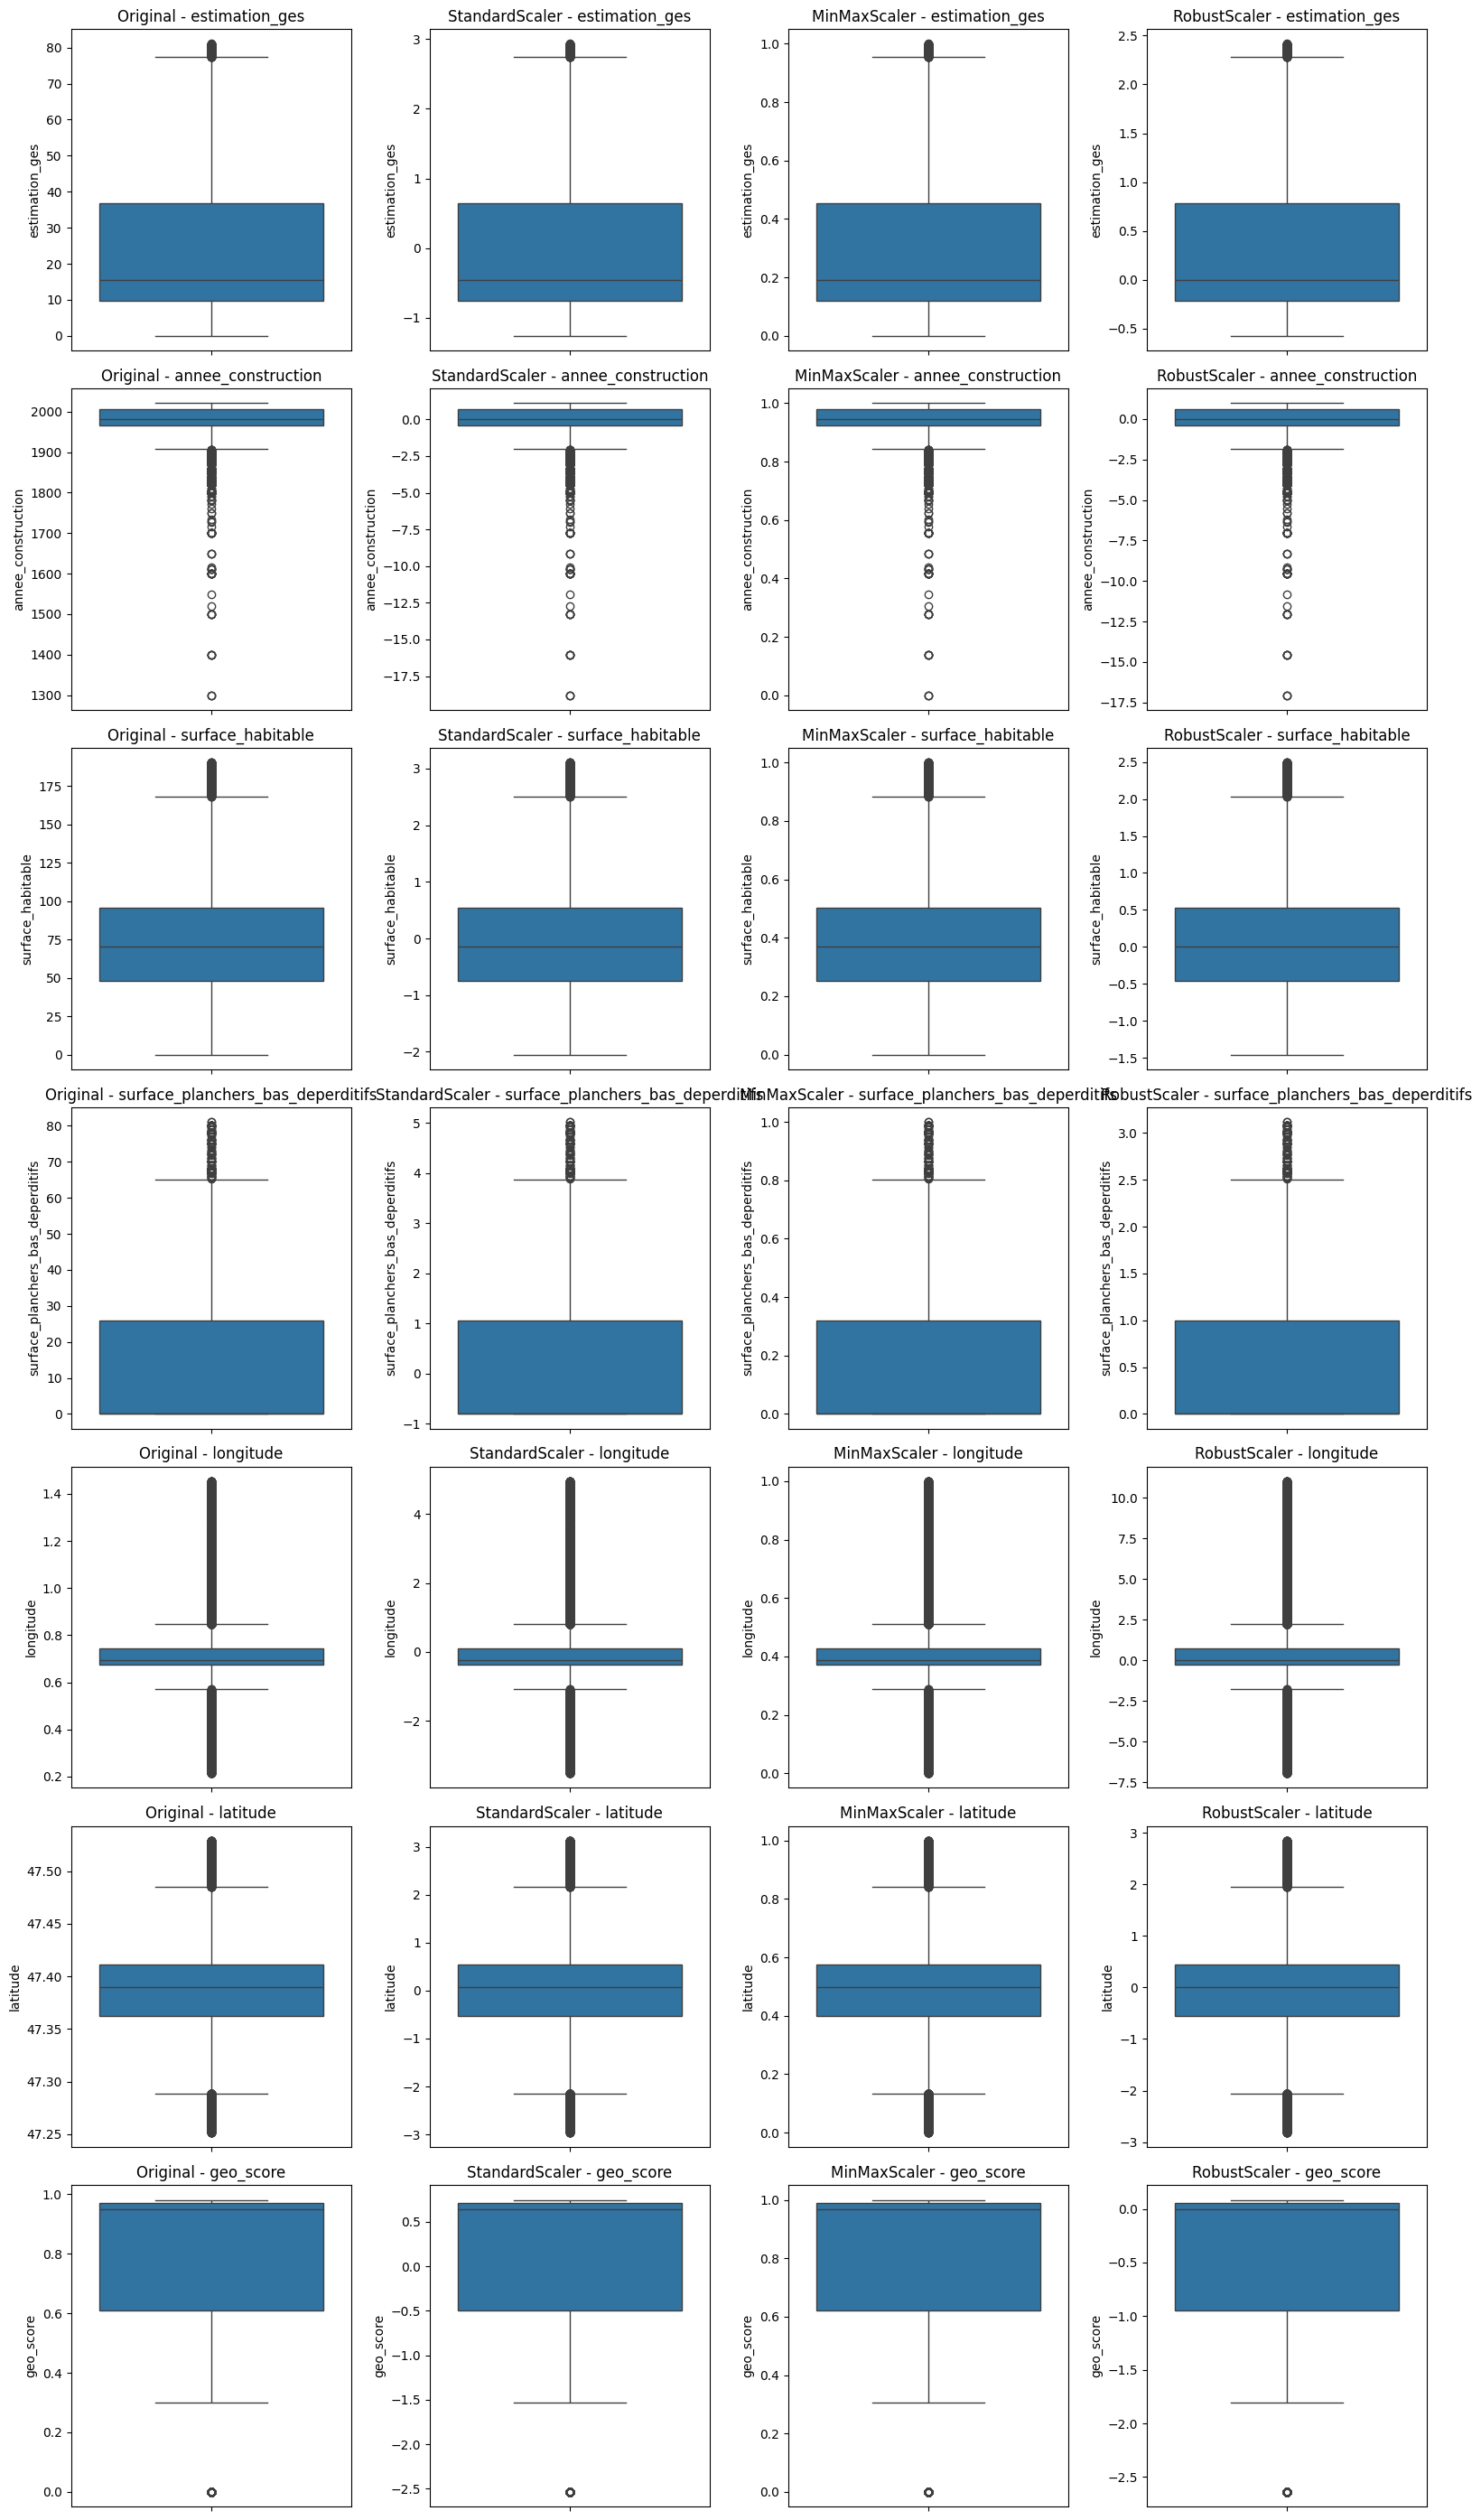

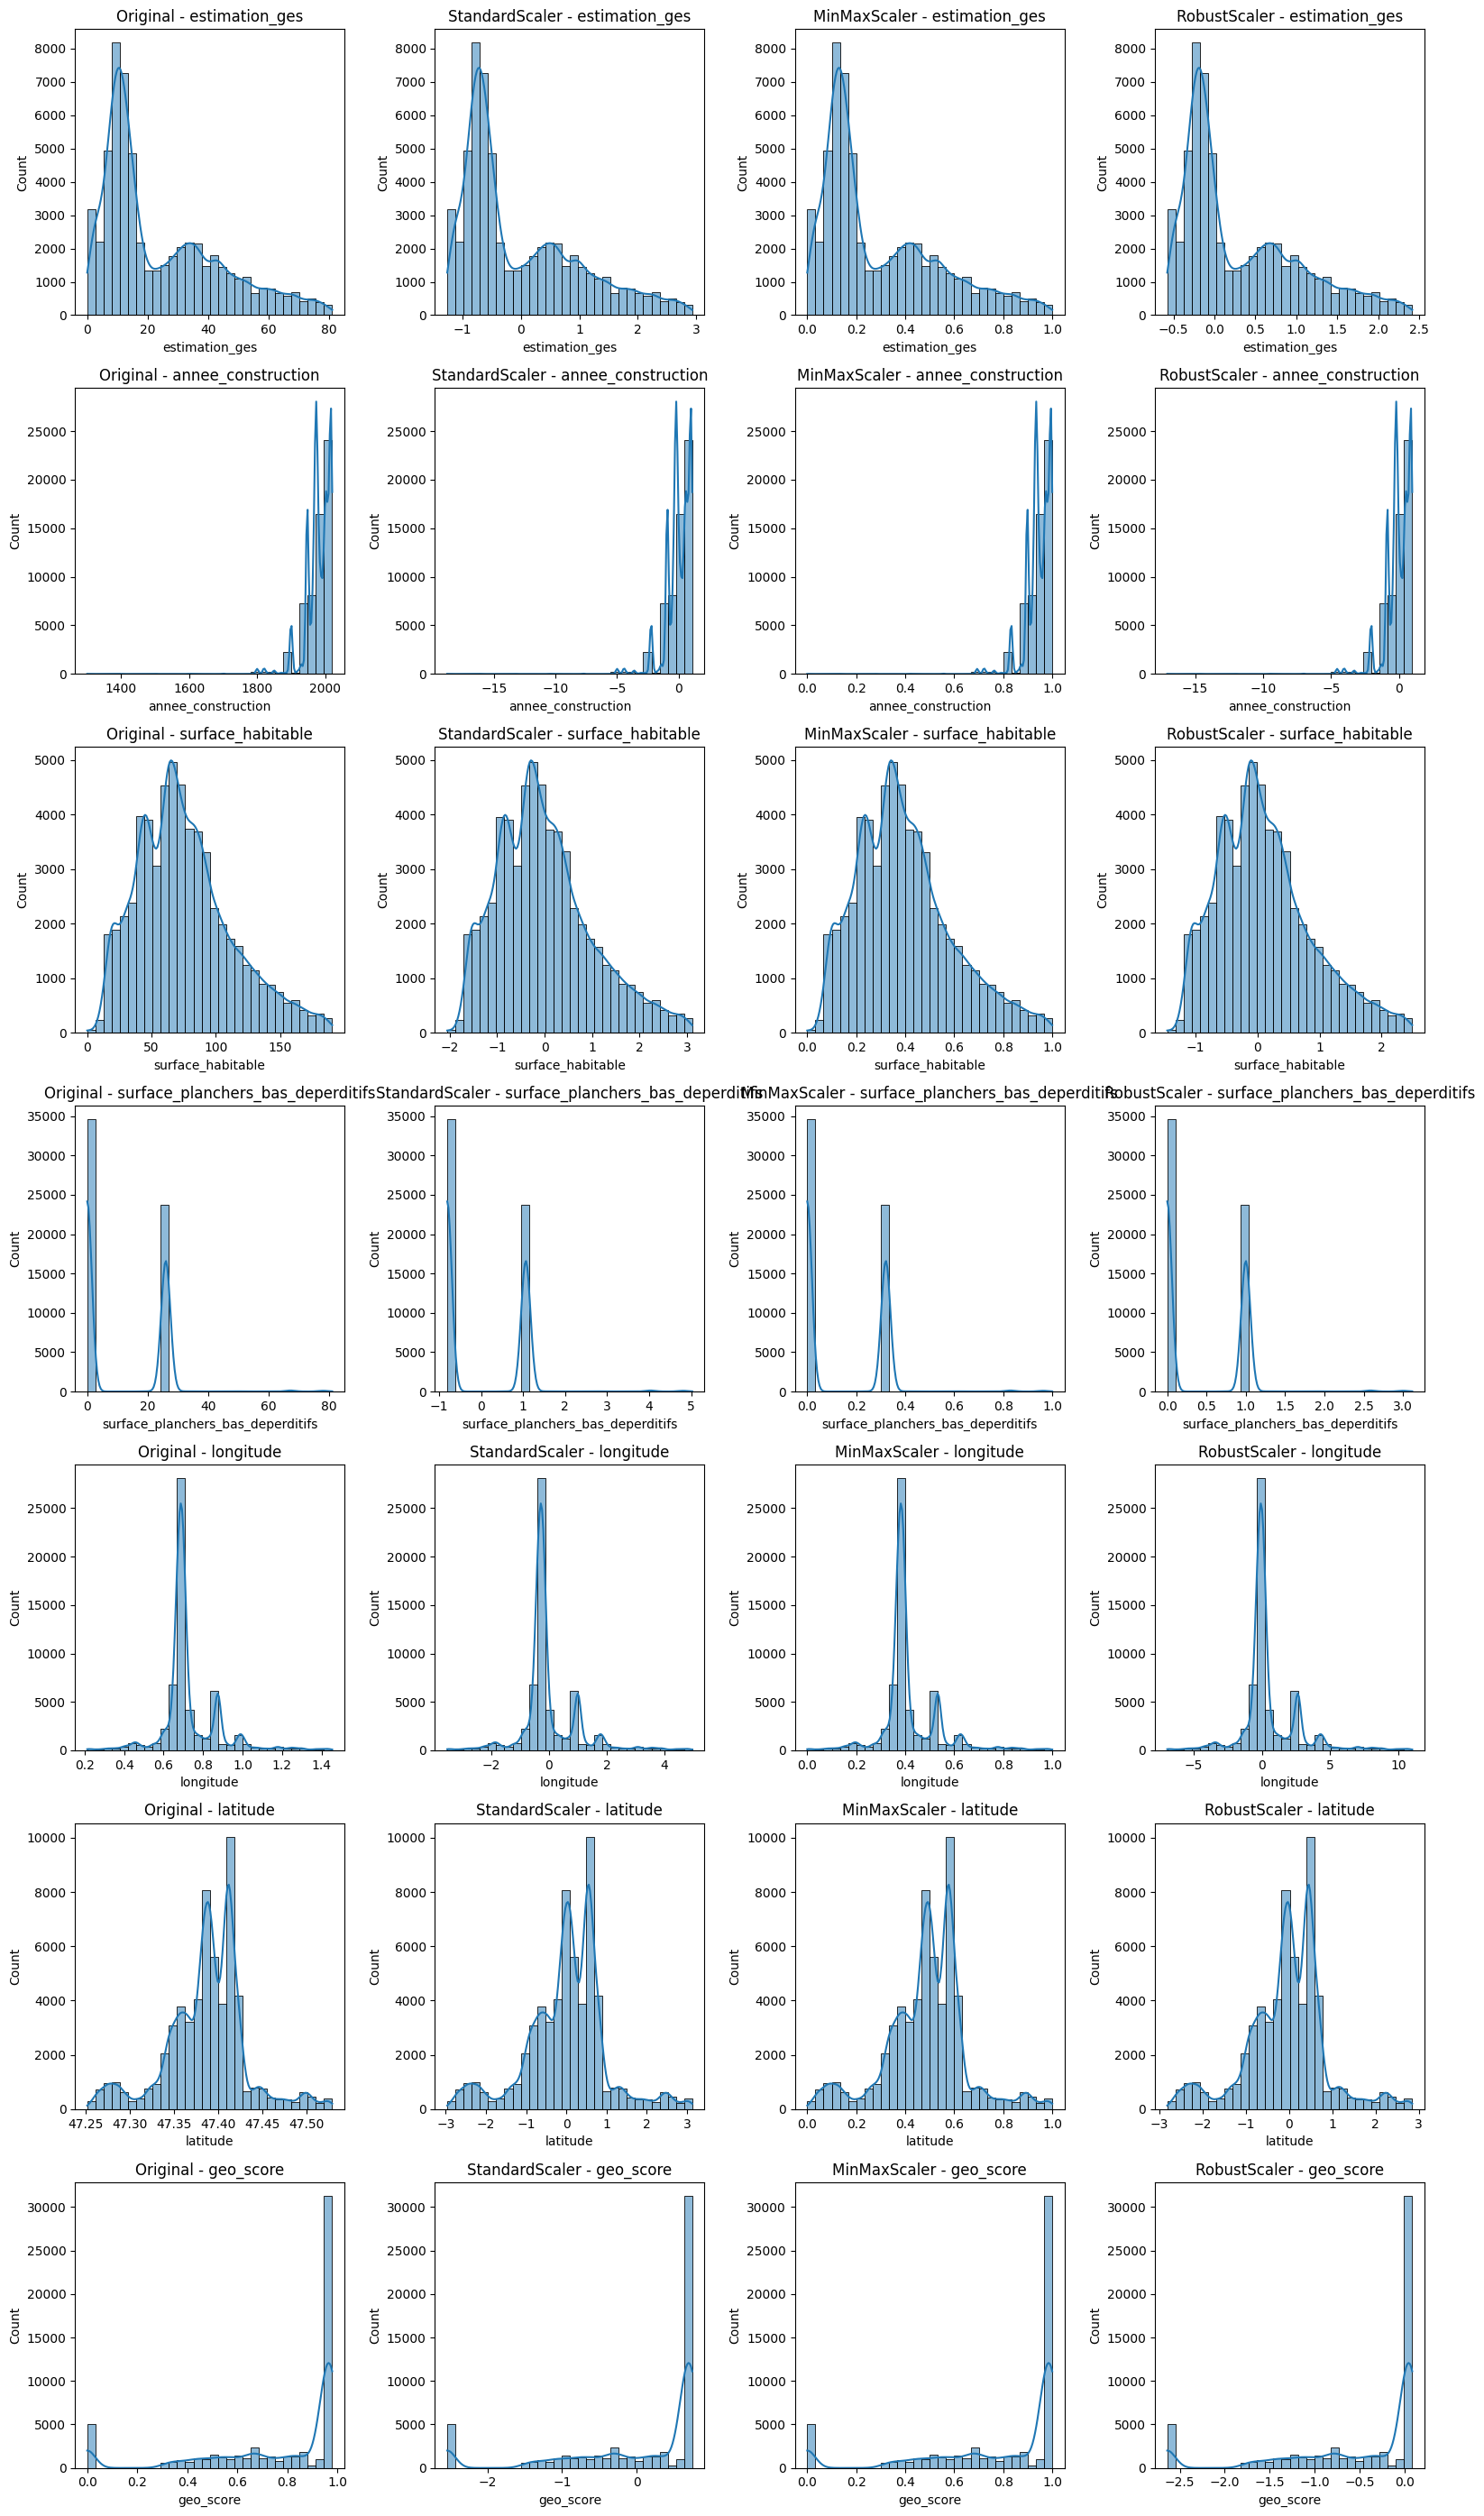

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pandas as pd

quantitative_df

# Identifier la variable cible
target_col = "consommation_energie"

# Séparer les features et la cible
X_quantitative = quantitative_df.drop(columns=[target_col])
y_target = quantitative_df[target_col]  # Ne pas normaliser la cible

# Appliquer les normalisations
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

# Dictionnaire pour stocker les résultats
scaled_dfs = {}

for name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_quantitative)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_quantitative.columns, index=quantitative_df.index)
    X_scaled_df[target_col] = y_target  # Ajouter la variable cible
    scaled_dfs[name] = X_scaled_df

# Comparaison des distributions avec boxplots
fig, axes = plt.subplots(nrows=len(X_quantitative.columns), ncols=4, figsize=(16, 4 * len(X_quantitative.columns)))

for i, col in enumerate(X_quantitative.columns):
    # Boxplot de la distribution originale
    sns.boxplot(y=quantitative_df[col], ax=axes[i, 0])
    axes[i, 0].set_title(f"Original - {col}")

    # Boxplot StandardScaler
    sns.boxplot(y=scaled_dfs["StandardScaler"][col], ax=axes[i, 1])
    axes[i, 1].set_title(f"StandardScaler - {col}")

    # Boxplot MinMaxScaler
    sns.boxplot(y=scaled_dfs["MinMaxScaler"][col], ax=axes[i, 2])
    axes[i, 2].set_title(f"MinMaxScaler - {col}")

    # Boxplot RobustScaler
    sns.boxplot(y=scaled_dfs["RobustScaler"][col], ax=axes[i, 3])
    axes[i, 3].set_title(f"RobustScaler - {col}")

# Ajustement de l'affichage
plt.tight_layout()
plt.show()

# Comparaison des distributions avec histogrammes
fig, axes = plt.subplots(nrows=len(X_quantitative.columns), ncols=4, figsize=(16, 4 * len(X_quantitative.columns)))

for i, col in enumerate(X_quantitative.columns):
    # Histogramme de la distribution originale
    sns.histplot(quantitative_df[col], ax=axes[i, 0], kde=True, bins=30)
    axes[i, 0].set_title(f"Original - {col}")

    # Histogramme StandardScaler
    sns.histplot(scaled_dfs["StandardScaler"][col], ax=axes[i, 1], kde=True, bins=30)
    axes[i, 1].set_title(f"StandardScaler - {col}")

    # Histogramme MinMaxScaler
    sns.histplot(scaled_dfs["MinMaxScaler"][col], ax=axes[i, 2], kde=True, bins=30)
    axes[i, 2].set_title(f"MinMaxScaler - {col}")

    # Histogramme RobustScaler
    sns.histplot(scaled_dfs["RobustScaler"][col], ax=axes[i, 3], kde=True, bins=30)
    axes[i, 3].set_title(f"RobustScaler - {col}")

# Ajustement de l'affichage
plt.tight_layout()
plt.show()

In [135]:
X_scaled_df = pd.concat([scaled_dfs['RobustScaler']])

In [136]:
X_scaled_df

estimation_ges  annee_construction  surface_habitable  \
2            -0.363368              -2.050          -0.564536   
3             1.445716              -2.050           0.473023   
5            -0.063516              -0.200           1.217784   
7             1.823855              -0.550           0.016497   
10            1.170236              -0.300          -0.029155   
...                ...                 ...                ...   
125460        0.616322              -1.050           0.719133   
125461        0.741137              -0.675           0.659784   
125463        0.369645               0.200           1.593588   
125466       -0.041359               0.000           0.182507   
125468       -0.133309              -0.875          -0.791762   

        surface_planchers_bas_deperditifs  longitude  latitude  geo_score  \
2                                     0.0   0.047689 -0.004387   0.083333   
3                                     0.0   2.624869  0.446164  -2.638889   
5                                     1.0   0.295433  0.034155   0.027778   
7                                     0.0  -0.322630  0.423979  -0.805556   
10                                    0.0  -0.030325 -0.131111   0.083333   
...                                   ...        ...       ...        ...   
125460                                0.0  -0.237302 -0.023770   0.083333   
125461                                0.0   0.007835 -0.624074  -0.250000   
125463                                0.0  -1.440872 -2.364531  -1.416667   
125466                                1.0  -0.999446 -2.354044   0.027778   
125468                                0.0   2.624869  0.446164  -2.638889   

        consommation_energie  
2                     177.12  
3                     234.04  
5                     278.63  
7                     361.30  
10                    202.15  
...                      ...  
125460                138.05  
125461                218.35  
125463                109.50  
125466                275.81  
125468                377.00  

[59186 rows x 8 columns]

In [137]:
categorical_df

nom_methode_dpe tr001_modele_dpe_type tr002_type_batiment_libelle
2            3CL - DPE              Location                 Appartement
3        Facture - DPE                 Vente                      Maison
5            3CL - DPE                 Vente                      Maison
7            3CL - DPE                 Vente                      Maison
10           3CL - DPE              Location                 Appartement
...                ...                   ...                         ...
125460   Facture - DPE                 Vente                 Appartement
125461       3CL - DPE                 Vente                      Maison
125463       3CL - DPE                 Vente                      Maison
125466       3CL - DPE                 Vente                      Maison
125468   Facture - DPE              Location                 Appartement

[59186 rows x 3 columns]

In [138]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Identifier les colonnes catégorielles avec peu de catégories (pour One-Hot Encoding)
one_hot_cols = [col for col in categorical_df.columns if categorical_df[col].nunique() <= 10]

# Appliquer One-Hot Encoding en gardant toutes les catégories
one_hot_encoder = OneHotEncoder(drop=None, sparse_output=False)
encoded_one_hot = one_hot_encoder.fit_transform(categorical_df[one_hot_cols])
encoded_one_hot_df = pd.DataFrame(encoded_one_hot, columns=one_hot_encoder.get_feature_names_out(one_hot_cols))

# S'assurer que l'index est aligné
encoded_one_hot_df.index = categorical_df.index  

# Identifier les colonnes restantes pour Label Encoding
label_cols = [col for col in categorical_df.columns if col not in one_hot_cols]

# Appliquer Label Encoding sur les autres colonnes (avec un encodeur différent par colonne)
for col in label_cols:
    le = LabelEncoder()
    categorical_df[col] = le.fit_transform(categorical_df[col])

# Fusionner les données encodées
categorical_encoded_df = pd.concat([categorical_df, encoded_one_hot_df], axis=1).drop(columns=one_hot_cols)

# Sauvegarder le fichier
# categorical_encoded_df.to_excel("categorical_encoded.xlsx", index=False)

print("✅ Encodage terminé. Toutes les valeurs sont bien encodées.")


✅ Encodage terminé. Toutes les valeurs sont bien encodées.


In [139]:
categorical_encoded_df

nom_methode_dpe_3CL - DPE  nom_methode_dpe_ECS  \
2                             1.0                  0.0   
3                             0.0                  0.0   
5                             1.0                  0.0   
7                             1.0                  0.0   
10                            1.0                  0.0   
...                           ...                  ...   
125460                        0.0                  0.0   
125461                        1.0                  0.0   
125463                        1.0                  0.0   
125466                        1.0                  0.0   
125468                        0.0                  0.0   

        nom_methode_dpe_Facture - DPE  nom_methode_dpe_Th-BCE  \
2                                 0.0                     0.0   
3                                 1.0                     0.0   
5                                 0.0                     0.0   
7                                 0.0                     0.0   
10                                0.0                     0.0   
...                               ...                     ...   
125460                            1.0                     0.0   
125461                            0.0                     0.0   
125463                            0.0                     0.0   
125466                            0.0                     0.0   
125468                            1.0                     0.0   

        nom_methode_dpe_Th-C-E  tr001_modele_dpe_type_Copropriété  \
2                          0.0                                0.0   
3                          0.0                                0.0   
5                          0.0                                0.0   
7                          0.0                                0.0   
10                         0.0                                0.0   
...                        ...                                ...   
125460                     0.0                                0.0   
125461                     0.0                                0.0   
125463                     0.0                                0.0   
125466                     0.0                                0.0   
125468                     0.0                                0.0   

        tr001_modele_dpe_type_Location  tr001_modele_dpe_type_Neuf  \
2                                  1.0                         0.0   
3                                  0.0                         0.0   
5                                  0.0                         0.0   
7                                  0.0                         0.0   
10                                 1.0                         0.0   
...                                ...                         ...   
125460                             0.0                         0.0   
125461                             0.0                         0.0   
125463                             0.0                         0.0   
125466                             0.0                         0.0   
125468                             1.0                         0.0   

        tr001_modele_dpe_type_Vente  tr002_type_batiment_libelle_Appartement  \
2                               0.0                                      1.0   
3                               1.0                                      0.0   
5                               1.0                                      0.0   
7                               1.0                                      0.0   
10                              0.0                                      1.0   
...                             ...                                      ...   
125460                          1.0                                      1.0   
125461                          1.0                                      0.0   
125463                          1.0                                      0.0   
125466                          1.0                         

In [140]:
import pandas as pd


# Fusionner les datasets sur l'index
merged_data_train = pd.concat([X_scaled_df,categorical_encoded_df], axis=1)

# Vérifier si tout est bien aligné
merged_data_train
print("✅ Fusion terminée. Fichier enregistré sous 'final_dataset.xlsx'.")

✅ Fusion terminée. Fichier enregistré sous 'final_dataset.xlsx'.


In [141]:
merged_data_train.to_csv('final_dataset_train.csv', index=False)

# Phase 3

In [142]:
merged_data_train = pd.read_csv('final_dataset_train.csv')

In [143]:
merged_data_train

estimation_ges  annee_construction  surface_habitable  \
0           -0.363368              -2.050          -0.564536   
1            1.445716              -2.050           0.473023   
2           -0.063516              -0.200           1.217784   
3            1.823855              -0.550           0.016497   
4            1.170236              -0.300          -0.029155   
...               ...                 ...                ...   
59181        0.616322              -1.050           0.719133   
59182        0.741137              -0.675           0.659784   
59183        0.369645               0.200           1.593588   
59184       -0.041359               0.000           0.182507   
59185       -0.133309              -0.875          -0.791762   

       surface_planchers_bas_deperditifs  longitude  latitude  geo_score  \
0                                    0.0   0.047689 -0.004387   0.083333   
1                                    0.0   2.624869  0.446164  -2.638889   
2                                    1.0   0.295433  0.034155   0.027778   
3                                    0.0  -0.322630  0.423979  -0.805556   
4                                    0.0  -0.030325 -0.131111   0.083333   
...                                  ...        ...       ...        ...   
59181                                0.0  -0.237302 -0.023770   0.083333   
59182                                0.0   0.007835 -0.624074  -0.250000   
59183                                0.0  -1.440872 -2.364531  -1.416667   
59184                                1.0  -0.999446 -2.354044   0.027778   
59185                                0.0   2.624869  0.446164  -2.638889   

       consommation_energie  nom_methode_dpe_3CL - DPE  nom_methode_dpe_ECS  \
0                    177.12                        1.0                  0.0   
1                    234.04                        0.0                  0.0   
2                    278.63                        1.0                  0.0   
3                    361.30                        1.0                  0.0   
4                    202.15                        1.0                  0.0   
...                     ...                        ...                  ...   
59181                138.05                        0.0                  0.0   
59182                218.35                        1.0                  0.0   
59183                109.50                        1.0                  0.0   
59184                275.81                        1.0                  0.0   
59185                377.00                        0.0                  0.0   

       nom_methode_dpe_Facture - DPE  nom_methode_dpe_Th-BCE  \
0                                0.0                     0.0   
1                                1.0                     0.0   
2                                0.0                     0.0   
3                                0.0                     0.0   
4                                0.0                     0.0   
...                              ...                     ...   
59181                            1.0                     0.0   
59182                            0.0                     0.0   
59183                            0.0                     0.0   
59184                            0.0                     0.0   
59185                            1.0                     0.0   

       nom_methode_dpe_Th-C-E  tr001_modele_dpe_type_Copropriété  \
0                         0.0                                0.0   
1                         0.0                                0.0   
2                         0.0                                0.0   
3                         0.0                                0.0   
4                         0.0                                0.0   
...                       ...                                ...   
59181                     0.0                                0.0   
59182                     0.0                                0.

In [144]:
merged_data_train.to_csv("final_dataset_for_train.csv", index=False)

In [145]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Définir la variable cible
target_col = "consommation_energie"

# Séparer X (features) et y (cible)
X = merged_data_train.drop(columns=[target_col])
y = merged_data_train[target_col]

# Split 85% entraînement, 15% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Afficher les tailles
print(f"Taille du jeu d'entraînement : {X_train.shape[0]} ({len(X_train)/len(X):.1%})")
print(f"Taille du jeu de validation : {X_val.shape[0]} ({len(X_val)/len(X):.1%})")

Taille du jeu d'entraînement : 47348 (80.0%)
Taille du jeu de validation : 11838 (20.0%)


### No Linear Models

In [ ]:
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ✅ Cross-Validation à 4 folds
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# ✅ Modèle RandomForest
rf_model_st = RandomForestRegressor()

# ✅ Prédictions avec Cross-Validation sur X_train
y_train_cv_pred = cross_val_predict(rf_model_st, X_train, y_train, cv=kf, n_jobs=-1)

# ✅ Entraînement du modèle final sur X_train complet
rf_model_st.fit(X_train, y_train)

# ✅ Prédiction sur le jeu de validation
y_val_pred = rf_model_st.predict(X_val)

# ✅ Fonction d'évaluation (MAE et RMSE)
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n📊 {dataset_name} :")
    print(f"🔹 MAE: {mae:.2f}")
    print(f"🔹 RMSE: {rmse:.2f}")

# ✅ Évaluations
evaluate_model(y_train, y_train_cv_pred, "Train (Cross-Validation)")
evaluate_model(y_val, y_val_pred, "Validation (Final Model)")


📊 Train (Cross-Validation) :
🔹 MAE: 17.01
🔹 RMSE: 36.44

📊 Validation (Final Model) :
🔹 MAE: 16.07
🔹 RMSE: 34.78


In [185]:
import pandas as pd

# ✅ Prédire sur le jeu de validation
y_val_pred = rf_model_st.predict(X_val)

# ✅ Créer un DataFrame avec les features
df_val_with_preds = X_val.copy()

# ✅ Ajouter la prédiction et la consommation réelle
df_val_with_preds["Predicted_Consommation"] = y_val_pred
df_val_with_preds["Actual_Consommation"] = y_val.values

# ✅ Sélectionner 20 lignes aléatoires pour inspection
sample_20 = df_val_with_preds.sample(n=20, random_state=42)

# ✅ Afficher le résultat
print(sample_20)

       estimation_ges  annee_construction  surface_habitable  \
35445       -0.077917               0.925          -0.038701   
8029         1.544313              -0.375           0.915646   
51295       -0.046160               0.950          -0.550840   
26307        0.624446              -0.200           0.590060   
17128       -0.298375               0.850          -0.802967   
53681       -0.310561              -2.050          -0.460780   
9687         0.002954               0.125           1.240818   
9235        -0.060192               0.825          -0.602096   
47020       -0.383309               0.950          -1.077091   
21126        1.134786              -3.300           0.195995   
41715        1.002216              -0.875           0.649409   
51975       -0.499631               0.875           1.969184   
35140       -0.244830               0.925          -0.341461   
49212        1.237075              -0.300          -0.398527   
52316       -0.488183               0.97

In [186]:
sample_20.to_csv("val_predictions_sample.csv", index=False)

In [196]:
sample_20.to_excel("val_predictions_sample.xlsx", index=False)

In [187]:
import numpy as np
import pandas as pd

# Liste des features utilisées
features = [
    "estimation_ges", "annee_construction", "surface_habitable", "surface_planchers_bas_deperditifs",
    "longitude", "latitude", "geo_score",
    "nom_methode_dpe_3CL - DPE", "nom_methode_dpe_ECS", "nom_methode_dpe_Facture - DPE", 
    "nom_methode_dpe_Th-BCE", "nom_methode_dpe_Th-C-E",
    "tr001_modele_dpe_type_Copropriété", "tr001_modele_dpe_type_Location", "tr001_modele_dpe_type_Neuf", "tr001_modele_dpe_type_Vente",
    "tr002_type_batiment_libelle_Appartement", "tr002_type_batiment_libelle_Logements collectifs", "tr002_type_batiment_libelle_Maison"
]

# Créer une ligne avec des zéros
X_test_zeros = pd.DataFrame([np.zeros(len(features))], columns=features)

# Prédiction
predicted_value = rf_model_st.predict(X_test_zeros)[0]

print(f"🔍 Prediction for all-zero input: {predicted_value:.2f} kWh/m²/year")


🔍 Prediction for all-zero input: 300.33 kWh/m²/year


In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ✅ Cross-Validation à 4 folds
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# ✅ Modèle RandomForest
rf_model = RandomForestRegressor(
    n_estimators=900, 
    max_depth=14,
    min_samples_split=8,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

# ✅ Prédictions avec Cross-Validation sur X_train
y_train_cv_pred = cross_val_predict(rf_model, X_train, y_train, cv=kf, n_jobs=-1)

# ✅ Entraînement du modèle final sur X_train complet
rf_model.fit(X_train, y_train)

# ✅ Prédiction sur le jeu de validation
y_val_pred = rf_model.predict(X_val)

# ✅ Fonction d'évaluation (MAE et RMSE)
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n📊 {dataset_name} :")
    print(f"🔹 MAE: {mae:.2f}")
    print(f"🔹 RMSE: {rmse:.2f}")

# ✅ Évaluations
evaluate_model(y_train, y_train_cv_pred, "Train (Cross-Validation)")
evaluate_model(y_val, y_val_pred, "Validation (Final Model)")



📊 Train (Cross-Validation) :
🔹 MAE: 18.26
🔹 RMSE: 37.07

📊 Validation (Final Model) :
🔹 MAE: 17.70
🔹 RMSE: 35.91


In [148]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ✅ Step 1: Define the parameter grid
param_grid = {
    'n_estimators': [900],
    'max_depth': [10, 14],
    'min_samples_split': [4, 8],
    'min_samples_leaf': [1, 2]
}

# ✅ Step 2: Setup 4-fold cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# ✅ Step 3: Initialize the model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# ✅ Step 4: Halving Grid Search
halving_search = HalvingGridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=kf,
    factor=2,  # Increase resources by a factor of 2
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# ✅ Step 5: Fit on training data
halving_search.fit(X_train, y_train)

# ✅ Step 6: Retrieve best model
best_rf_model = halving_search.best_estimator_
print(f"🎯 Best Parameters: {halving_search.best_params_}")

# ✅ Step 7: Evaluate best model
y_train_cv_pred = cross_val_predict(best_rf_model, X_train, y_train, cv=kf, n_jobs=-1)

best_rf_model.fit(X_train, y_train)
y_val_pred = best_rf_model.predict(X_val)

# ✅ Evaluation function
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n📊 {dataset_name} :")
    print(f"🔹 MAE: {mae:.2f}")
    print(f"🔹 RMSE: {rmse:.2f}")

# ✅ Evaluate performance
evaluate_model(y_train, y_train_cv_pred, "Train (Cross-Validation)")
evaluate_model(y_val, y_val_pred, "Validation (Tuned RandomForest)")


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 5918
max_resources_: 47348
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 5918
Fitting 4 folds for each of 8 candidates, totalling 32 fits
----------
iter: 1
n_candidates: 4
n_resources: 11836
Fitting 4 folds for each of 4 candidates, totalling 16 fits
----------
iter: 2
n_candidates: 2
n_resources: 23672
Fitting 4 folds for each of 2 candidates, totalling 8 fits
----------
iter: 3
n_candidates: 1
n_resources: 47344
Fitting 4 folds for each of 1 candidates, totalling 4 fits
🎯 Best Parameters: {'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 900}

📊 Train (Cross-Validation) :
🔹 MAE: 18.11
🔹 RMSE: 36.91

📊 Validation (Tuned RandomForest) :
🔹 MAE: 17.53
🔹 RMSE: 35.73


In [149]:
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [150]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

# ✅ Proper MAE Scorer for sklearn
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ✅ Objective Function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 6, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    # Use -MAE because Optuna maximizes
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)

    return scores.mean()  # negative MAE

# ✅ Run optimization
study = optuna.create_study(direction='maximize')  # Maximize because it's neg-MAE
study.optimize(objective, n_trials=30, timeout=600)

# ✅ Best results
print("✅ Best hyperparameters:", study.best_params)
print("📉 Best score (MAE):", -study.best_value)

# ✅ Train final model
best_model = RandomForestRegressor(**study.best_params)
best_model.fit(X_train, y_train)

# ✅ Predict and evaluate
y_val_pred = best_model.predict(X_val)

# ✅ Fonction d'évaluation (MAE et RMSE)
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n📊 {dataset_name} :")
    print(f"🔹 MAE: {mae:.2f}")
    print(f"🔹 RMSE: {rmse:.2f}")

# ✅ Évaluations
evaluate_model(y_train, y_train_cv_pred, "Train (Cross-Validation)")
evaluate_model(y_val, y_val_pred, "Validation (Final Model)")

[I 2025-04-13 13:59:49,414] A new study created in memory with name: no-name-0bda0f51-f6ca-4242-a8eb-a9d6ef335b7c
[I 2025-04-13 14:00:29,507] Trial 0 finished with value: -17.890956573216293 and parameters: {'n_estimators': 452, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: -17.890956573216293.
[I 2025-04-13 14:01:06,644] Trial 1 finished with value: -19.636113004479498 and parameters: {'n_estimators': 468, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: -17.890956573216293.
[I 2025-04-13 14:01:53,900] Trial 2 finished with value: -17.36612908526574 and parameters: {'n_estimators': 472, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: -17.36612908526574.
[I 2025-04-13 14:02:07,117] Trial 3 finished with value: -26.08720255334145 and parameters: {'n_estimators': 245, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with 

✅ Best hyperparameters: {'n_estimators': 406, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 2}
📉 Best score (MAE): 17.338409591750587

📊 Train (Cross-Validation) :
🔹 MAE: 18.11
🔹 RMSE: 36.91

📊 Validation (Final Model) :
🔹 MAE: 16.52
🔹 RMSE: 34.93


In [151]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ✅ Étape 1 : Initialiser le modèle
hgb_model_st = HistGradientBoostingRegressor()

# ✅ Étape 2 : Cross-validation sur X_train
kf = KFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(hgb_model_st, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"📊 Cross-Validation R² (Train) : {scores.mean():.2f}")

# ✅ Étape 3 : Entraînement final sur l’ensemble de X_train
hgb_model_st.fit(X_train, y_train)

# ✅ Étape 4 : Prédictions sur X_train et X_val
y_train_pred = hgb_model_st.predict(X_train)
y_val_pred = hgb_model_st.predict(X_val)

# ✅ Fonction d'évaluation
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

# ✅ Étape 5 : Affichage des performances
evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_val, y_val_pred, "Validation")


📊 Cross-Validation R² (Train) : 0.84

📈 Train Metrics:
MAE : 20.55
RMSE: 35.77

📈 Validation Metrics:
MAE : 21.30
RMSE: 37.55


In [152]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# squared_error, poisson
# ✅ Étape 1 : Initialiser le modèle
hgb_model = HistGradientBoostingRegressor(loss="squared_error", max_iter=200, random_state=42)

# ✅ Étape 2 : Cross-validation sur X_train
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(hgb_model, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"📊 Cross-Validation R² (Train) : {scores.mean():.2f}")

# ✅ Étape 3 : Entraînement final sur l’ensemble de X_train
hgb_model.fit(X_train, y_train)

# ✅ Étape 4 : Prédictions sur X_train et X_val
y_train_pred = hgb_model.predict(X_train)
y_val_pred = hgb_model.predict(X_val)

# ✅ Fonction d'évaluation
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

# ✅ Étape 5 : Affichage des performances
evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_val, y_val_pred, "Validation")


📊 Cross-Validation R² (Train) : 0.85

📈 Train Metrics:
MAE : 18.44
RMSE: 32.98

📈 Validation Metrics:
MAE : 19.85
RMSE: 36.23


In [153]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ✅ Paramètre grid réduit pour accélérer le tuning
param_grid = {
    'max_iter': [100, 200],
    'max_depth': [None, 14],
    'learning_rate': [0.05, 0.1]
}

# ✅ Cross-validation à 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ✅ Modèle de base
hgb_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42)

# ✅ Halving Grid Search
halving_search = HalvingGridSearchCV(
    estimator=hgb_model,
    param_grid=param_grid,
    factor=2,
    cv=kf,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

# ✅ Entraînement sur X_train
halving_search.fit(X_train, y_train)

# ✅ Meilleur modèle après tuning
best_hgb_model = halving_search.best_estimator_
print(f"🎯 Best Parameters: {halving_search.best_params_}")

# ✅ Prédictions
y_train_pred = best_hgb_model.predict(X_train)
y_val_pred = best_hgb_model.predict(X_val)

# ✅ Évaluation
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²   : {r2:.2f}")

# ✅ Résultats
evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_val, y_val_pred, "Validation")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 5918
max_resources_: 47348
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 5918
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 4
n_resources: 11836
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 23672
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 3
n_candidates: 1
n_resources: 47344
Fitting 5 folds for each of 1 candidates, totalling 5 fits
🎯 Best Parameters: {'learning_rate': 0.1, 'max_depth': 14, 'max_iter': 200}

📈 Train Metrics:
MAE : 18.43
RMSE: 33.02
R²   : 0.88

📈 Validation Metrics:
MAE : 19.82
RMSE: 36.17
R²   : 0.86


In [154]:
import optuna
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ✅ Objectif de l’optimisation
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_iter": trial.suggest_int("max_iter", 450, 900),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "random_state": 42
    }
    
    model = HistGradientBoostingRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    score = cross_val_score(
        model, X_train, y_train, 
        cv=kf, 
        scoring="neg_mean_absolute_error", 
        n_jobs=-1
    )
    
    return -score.mean()

# ✅ Étude Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# ✅ Meilleurs paramètres
print("🎯 Best hyperparameters:", study.best_params)
print("📉 Best score (MAE):", study.best_value)

# ✅ Entraîner le modèle final avec les meilleurs paramètres
best_hgb_model = HistGradientBoostingRegressor(**study.best_params)
best_hgb_model.fit(X_train, y_train)

# ✅ Prédictions
y_train_pred = best_hgb_model.predict(X_train)
y_val_pred = best_hgb_model.predict(X_val)

# ✅ Évaluation
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²   : {r2:.2f}")

evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_val, y_val_pred, "Validation")

[I 2025-04-13 14:11:49,274] A new study created in memory with name: no-name-e721a98d-0788-423c-807b-21c4d90bc12a
[I 2025-04-13 14:11:52,580] Trial 0 finished with value: 20.36089627380959 and parameters: {'learning_rate': 0.09229012225995238, 'max_iter': 481, 'max_depth': 6}. Best is trial 0 with value: 20.36089627380959.
[I 2025-04-13 14:11:56,713] Trial 1 finished with value: 20.434064404842832 and parameters: {'learning_rate': 0.06450973030594769, 'max_iter': 586, 'max_depth': 6}. Best is trial 0 with value: 20.36089627380959.
[I 2025-04-13 14:11:59,239] Trial 2 finished with value: 20.479029261090293 and parameters: {'learning_rate': 0.121711312225793, 'max_iter': 799, 'max_depth': 6}. Best is trial 0 with value: 20.36089627380959.
[I 2025-04-13 14:12:02,597] Trial 3 finished with value: 20.13551585263486 and parameters: {'learning_rate': 0.08029790932189354, 'max_iter': 511, 'max_depth': 8}. Best is trial 3 with value: 20.13551585263486.
[I 2025-04-13 14:12:04,729] Trial 4 finish

🎯 Best hyperparameters: {'learning_rate': 0.12381872744836822, 'max_iter': 689, 'max_depth': 10}
📉 Best score (MAE): 19.556803247878168

📈 Train Metrics:
MAE : 15.58
RMSE: 28.57
R²   : 0.91

📈 Validation Metrics:
MAE : 18.95
RMSE: 35.58
R²   : 0.86


In [155]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modèle XGBoost avec tuning de base
xgb_model_st = XGBRegressor()

# Entraînement sur X_train
xgb_model_st.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Prédictions
y_train_pred_xgb = xgb_model_st.predict(X_train)
y_val_pred_xgb = xgb_model_st.predict(X_val)

# Fonction d'évaluation
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Évaluations
evaluate_model(y_train, y_train_pred_xgb, "Train (XGBoost)")
evaluate_model(y_val, y_val_pred_xgb, "Validation (XGBoost)")


📈 Train (XGBoost) Metrics:
MAE: 17.04
RMSE: 30.29

📈 Validation (XGBoost) Metrics:
MAE: 19.88
RMSE: 36.05


In [156]:

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modèle XGBoost avec tuning de base
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=5,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

# Entraînement sur X_train
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Prédictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)

# Fonction d'évaluation
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Évaluations
evaluate_model(y_train, y_train_pred_xgb, "Train (XGBoost)")
evaluate_model(y_val, y_val_pred_xgb, "Validation (XGBoost)")


📈 Train (XGBoost) Metrics:
MAE: 19.04
RMSE: 33.86

📈 Validation (XGBoost) Metrics:
MAE: 20.54
RMSE: 36.82


In [157]:
from xgboost import XGBRegressor
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ✅ Paramètres légers pour un tuning rapide
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [6],
    'learning_rate': [0.05]
}

# ✅ Cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# ✅ Base XGBoost model
xgb_base = XGBRegressor(
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=5,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# ✅ HalvingGridSearch
halving_search = HalvingGridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    factor=2,
    cv=kf,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

# ✅ Entraînement du modèle
halving_search.fit(X_train, y_train)

# ✅ Meilleur modèle
best_xgb = halving_search.best_estimator_
print(f"🎯 Best Parameters: {halving_search.best_params_}")

# ✅ Prédictions
y_train_pred_xgb = best_xgb.predict(X_train)
y_val_pred_xgb = best_xgb.predict(X_val)

# ✅ Fonction d’évaluation
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# ✅ Évaluations finales
evaluate_model(y_train, y_train_pred_xgb, "Train (XGBoost Tuned)")
evaluate_model(y_val, y_val_pred_xgb, "Validation (XGBoost Tuned)")

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 23674
max_resources_: 47348
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 23674
Fitting 4 folds for each of 2 candidates, totalling 8 fits
----------
iter: 1
n_candidates: 1
n_resources: 47348
Fitting 4 folds for each of 1 candidates, totalling 4 fits
🎯 Best Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}

📈 Train (XGBoost Tuned) Metrics:
MAE: 19.04
RMSE: 33.86
R²: 0.88

📈 Validation (XGBoost Tuned) Metrics:
MAE: 20.54
RMSE: 36.82
R²: 0.86


In [158]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ✅ Fonction d'objectif pour Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.05),
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 5,
        'reg_lambda': 1,
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }

    model = XGBRegressor(**params)
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    
    score = cross_val_score(model, X_train, y_train, 
                            scoring='neg_mean_absolute_error',
                            cv=kf, n_jobs=-1)
    return -score.mean()

# ✅ Étude Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# ✅ Meilleur modèle
best_params = study.best_params
print("🎯 Best hyperparameters:", best_params)
print("📉 Best MAE (CV):", study.best_value)

best_xgb = XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

# ✅ Prédictions
y_train_pred = best_xgb.predict(X_train)
y_val_pred = best_xgb.predict(X_val)

# ✅ Évaluation
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

evaluate_model(y_train, y_train_pred, "Train (XGBoost - Optuna)")
evaluate_model(y_val, y_val_pred, "Validation (XGBoost - Optuna)")


[I 2025-04-13 14:13:22,634] A new study created in memory with name: no-name-1f6eb84e-b83e-4140-86a8-380873608562
[I 2025-04-13 14:13:23,530] Trial 0 finished with value: 37.38792556012132 and parameters: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.031118461307568547}. Best is trial 0 with value: 37.38792556012132.
[I 2025-04-13 14:13:24,299] Trial 1 finished with value: 39.18975986288963 and parameters: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.024276817744751534}. Best is trial 0 with value: 37.38792556012132.
[I 2025-04-13 14:13:25,304] Trial 2 finished with value: 30.1227894855885 and parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.04519317674639081}. Best is trial 2 with value: 30.1227894855885.
[I 2025-04-13 14:13:26,345] Trial 3 finished with value: 28.33620661018728 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.03098814845535234}. Best is trial 3 with value: 28.33620661018728.
[I 2025-04-13 14:13:27,552

🎯 Best hyperparameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.04819732956135083}
📉 Best MAE (CV): 21.47504946978821

📈 Train (XGBoost - Optuna) Metrics:
MAE: 19.59
RMSE: 34.87
R²: 0.87

📈 Validation (XGBoost - Optuna) Metrics:
MAE: 20.94
RMSE: 37.56
R²: 0.85


In [159]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Étape 1 : Initialisation du modèle KNN
knn_reg = KNeighborsRegressor(n_neighbors=3)

# Étape 2 : Cross-Validation sur Train
kf = KFold(n_splits=4, shuffle=True, random_state=42)
scores = cross_val_score(knn_reg, X_train, y_train, cv=kf, scoring='r2')
print(f"📊 Cross-Validation R² (KNN Regression) : {scores.mean():.2f}")

# Étape 3 : Entraînement final sur Train
knn_reg.fit(X_train, y_train)

# Prédictions sur Train, Validation et Test
y_train_pred_knn = knn_reg.predict(X_train)
y_val_pred_knn = knn_reg.predict(X_val)


# Fonction d'évaluation des modèles
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")


# Évaluation sur Train, Validation et Test
evaluate_model(y_train, y_train_pred_knn, "Train (KNN Regression)")
evaluate_model(y_val, y_val_pred_knn, "Validation (KNN Regression)")

📊 Cross-Validation R² (KNN Regression) : 0.74

📈 Train (KNN Regression) Metrics:
MAE: 17.78
RMSE: 33.05

📈 Validation (KNN Regression) Metrics:
MAE: 26.37
RMSE: 47.87


In [160]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ✅ Modèle avec tuning de base
lgbm_reg = LGBMRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# ✅ Entraînement avec early stopping
lgbm_reg.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='mae'
)

# ✅ Prédictions
y_train_pred_lgbm = lgbm_reg.predict(X_train)
y_val_pred_lgbm = lgbm_reg.predict(X_val)

# ✅ Fonction d'évaluation
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²  : {r2:.2f}")

# ✅ Évaluations
evaluate_model(y_train, y_train_pred_lgbm, "Train (LightGBM)")
evaluate_model(y_val, y_val_pred_lgbm, "Validation (LightGBM)")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 47348, number of used features: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 184.931743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [161]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Étape 1 : Initialisation du modèle CatBoost
catboost_reg = CatBoostRegressor(n_estimators=300, depth=14, learning_rate=0.1, random_state=42, verbose=0)

# Étape 2 : Cross-Validation sur Train
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(catboost_reg, X_train, y_train, cv=kf, scoring='r2')
print(f"📊 Cross-Validation R² (CatBoost) : {scores.mean():.2f}")

# Étape 3 : Entraînement final sur Train
catboost_reg.fit(X_train, y_train)

# Prédictions sur Train, Validation et Test
y_train_pred_catboost = catboost_reg.predict(X_train)
y_val_pred_catboost = catboost_reg.predict(X_val)


# Fonction d'évaluation des modèles
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
# Évaluation sur Train, Validation et Test
evaluate_model(y_train, y_train_pred_catboost, "Train (CatBoost)")
evaluate_model(y_val, y_val_pred_catboost, "Validation (CatBoost)")

📊 Cross-Validation R² (CatBoost) : 0.87

📈 Train (CatBoost) Metrics:
MAE: 12.26
RMSE: 22.90

📈 Validation (CatBoost) Metrics:
MAE: 17.76
RMSE: 34.31


### Linear Models

In [162]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# Étape 2 : Cross-Validation sur Train pour valider le modèle
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr_model = LinearRegression()

scores = cross_val_score(lr_model, X_train, y_train, cv=kf, scoring='r2')
print(f"📊 Cross-Validation R² : {scores.mean():.2f}")

# Étape 3 : Entraînement final et test sur X_test
lr_model.fit(X_train, y_train)

# Prédictions sur Train, Validation et Test
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Fonction d'évaluation des modèles
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")

# Évaluation sur les trois ensembles
evaluate_model(y_train, y_train_pred, "Train (Linear Regression)")
evaluate_model(y_val, y_val_pred, "Validation (Linear Regression)")


📊 Cross-Validation R² : 0.55

📈 Train (Linear Regression) Metrics:
MAE: 48.69

📈 Validation (Linear Regression) Metrics:
MAE: 49.27


In [163]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# Étape 1 : Initialisation du modèle Ridge
ridge_reg = Ridge(alpha=1.0)

# Étape 2 : Cross-Validation sur Train
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(ridge_reg, X_train, y_train, cv=kf, scoring='r2')
print(f"📊 Cross-Validation R² (Ridge Regression) : {scores.mean():.2f}")

# Étape 3 : Entraînement final sur Train
ridge_reg.fit(X_train, y_train)

# Prédictions sur Train, Validation et Test
y_train_pred_ridge = ridge_reg.predict(X_train)
y_val_pred_ridge = ridge_reg.predict(X_val)


# Fonction d'évaluation des modèles
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# Évaluation sur Train, Validation et Test
evaluate_model(y_train, y_train_pred_ridge, "Train (Ridge Regression)")
evaluate_model(y_val, y_val_pred_ridge, "Validation (Ridge Regression)")

📊 Cross-Validation R² (Ridge Regression) : 0.55

📈 Train (Ridge Regression) Metrics:
MAE: 48.69
RMSE: 65.06
R²: 0.55

📈 Validation (Ridge Regression) Metrics:
MAE: 49.27
RMSE: 65.54
R²: 0.54


In [164]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# Étape 1 : Initialisation du modèle Lasso
lasso_reg = Lasso(alpha=0.01)

# Étape 2 : Cross-Validation sur Train
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lasso_reg, X_train, y_train, cv=kf, scoring='r2')
print(f"📊 Cross-Validation R² (Lasso Regression) : {scores.mean():.2f}")

# Étape 3 : Entraînement final sur Train
lasso_reg.fit(X_train, y_train)

# Prédictions sur Train, Validation et Test
y_train_pred_lasso = lasso_reg.predict(X_train)
y_val_pred_lasso = lasso_reg.predict(X_val)


# Fonction d'évaluation des modèles
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# Évaluation sur Train, Validation et Test
evaluate_model(y_train, y_train_pred_lasso, "Train (Lasso Regression)")
evaluate_model(y_val, y_val_pred_lasso, "Validation (Lasso Regression)")

📊 Cross-Validation R² (Lasso Regression) : 0.55

📈 Train (Lasso Regression) Metrics:
MAE: 48.70
RMSE: 65.06
R²: 0.55

📈 Validation (Lasso Regression) Metrics:
MAE: 49.27
RMSE: 65.54
R²: 0.54


In [165]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 2: Initialize the Support Vector Regressor
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)  # RBF kernel with C=100 and epsilon=0.1

# Step 3: Cross-Validation on Train
kf = KFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(svr_model, X_train, y_train, cv=kf, scoring='r2')
print(f"📊 Cross-Validation R² (SVR): {scores.mean():.2f}")

# Step 4: Final Training on Train
svr_model.fit(X_train, y_train)

# Predictions on Train, Validation, and Test
y_train_pred_svr = svr_model.predict(X_train)
y_val_pred_svr = svr_model.predict(X_val)

# Function to evaluate models
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Evaluate on Train, Validation, and Test
evaluate_model(y_train, y_train_pred_svr, "Train (SVR)")
evaluate_model(y_val, y_val_pred_svr, "Validation (SVR)")


📊 Cross-Validation R² (SVR): 0.66

📈 Train (SVR) Metrics:
MAE: 33.96
RMSE: 54.54

📈 Validation (SVR) Metrics:
MAE: 34.99
RMSE: 55.44


### Analyse Approfondie — Comparaison RandomForest vs XGBoost vs HistGradientBoosting

C:\Users\tarek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


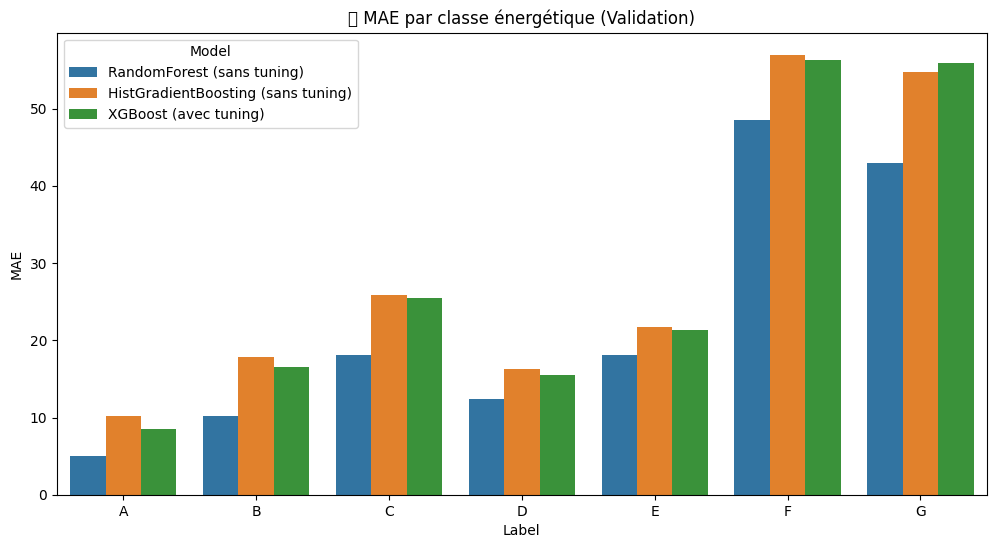

C:\Users\tarek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


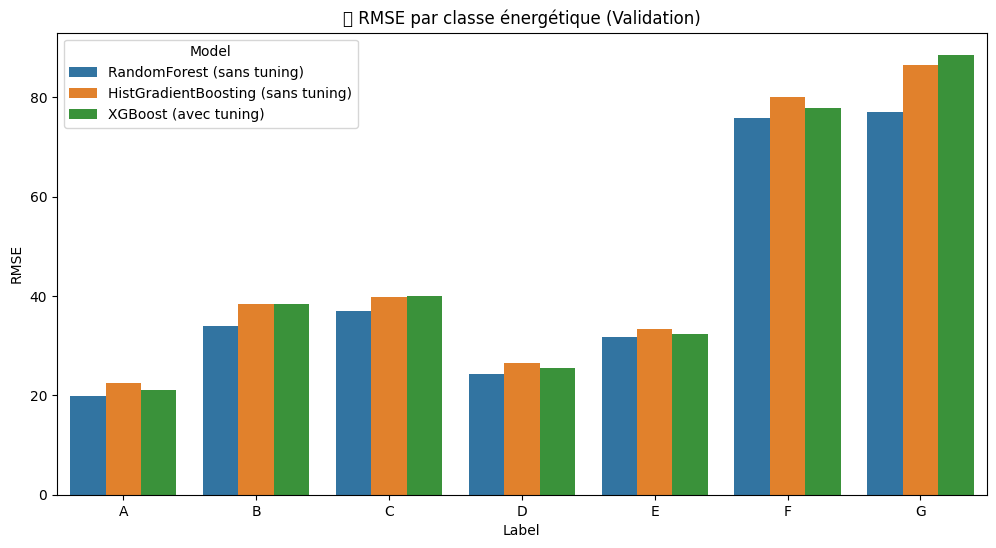

In [166]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Créer les labels (A → G)
def assign_label(value):
    if value < 51:
        return 'A'
    elif 51 <= value <= 90:
        return 'B'
    elif 91 <= value <= 150:
        return 'C'
    elif 151 <= value <= 230:
        return 'D'
    elif 231 <= value <= 330:
        return 'E'
    elif 331 <= value <= 450:
        return 'F'
    else:
        return 'G'

labels_val = y_val.apply(assign_label)

# Fonction d’évaluation par label pour plusieurs modèles
def evaluate_all_models_by_label(models_preds, y_true, labels, dataset_name="Validation"):
    results = []

    for model_name, y_pred in models_preds.items():
        for label in np.unique(labels):
            mask = labels == label
            mae = mean_absolute_error(y_true[mask], y_pred[mask])
            rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
            results.append({
                "Model": model_name,
                "Label": label,
                "MAE": round(mae, 2),
                "RMSE": round(rmse, 2),
                "Dataset": dataset_name
            })

    return pd.DataFrame(results)

# ✅ Prédictions sur validation
y_val_pred_rf = rf_model_st.predict(X_val)
y_val_pred_hgb = hgb_model_st.predict(X_val)
y_val_pred_xgb = xgb_model.predict(X_val)

# ✅ Comparer tous les modèles par classe
model_preds = {
    "RandomForest (sans tuning)": y_val_pred_rf,
    "HistGradientBoosting (sans tuning)": y_val_pred_hgb,
    "XGBoost (avec tuning)": y_val_pred_xgb
}

df_by_class = evaluate_all_models_by_label(model_preds, y_val, labels_val)

# ✅ Affichage lisible
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=df_by_class, x="Label", y="MAE", hue="Model")
plt.title("📊 MAE par classe énergétique (Validation)")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=df_by_class, x="Label", y="RMSE", hue="Model")
plt.title("📊 RMSE par classe énergétique (Validation)")
plt.show()

In [167]:
%pip install joblib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [168]:
import joblib
joblib.dump(rf_model_st, 'rf_model_st.pkl')

['rf_model_st.pkl']

In [172]:
def shap_summary_for_model(model, X_train, model_name):
    import shap
    import matplotlib.pyplot as plt

    print(f"\n📊 SHAP Summary pour {model_name}")
    
    num_samples = min(100, X_train.shape[0])
    X_sample = shap.sample(X_train, num_samples, random_state=42)

    if "RandomForestRegressor" in str(type(model)):
        explainer = shap.Explainer(model.predict, X_sample, algorithm="permutation")
        shap_values = explainer(X_sample)  # ✅ No check_additivity here
    elif "HistGradientBoosting" in str(type(model)):
        explainer = shap.Explainer(model, X_sample)
        shap_values = explainer(X_sample, check_additivity=False)  # ✅ Allowed
    elif "XGBRegressor" in str(type(model)):
        explainer = shap.Explainer(model, X_sample, model_output="raw")
        shap_values = explainer(X_sample)  # ✅ No check_additivity
    else:
        explainer = shap.Explainer(model, X_sample)
        shap_values = explainer(X_sample)

    shap.summary_plot(shap_values, X_sample, max_display=10)



📊 SHAP Summary pour RandomForest (sans tuning)


PermutationExplainer explainer: 101it [01:04,  1.45it/s]                         


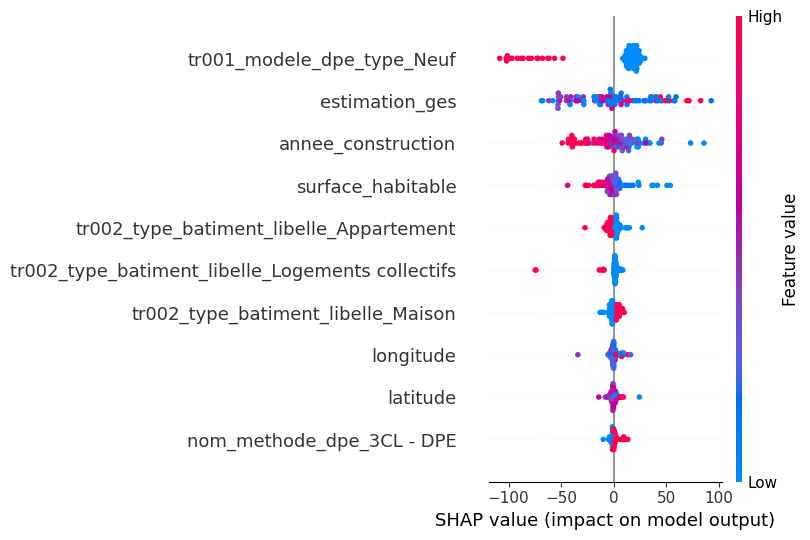

In [173]:
shap_summary_for_model(rf_model_st, X_train, "RandomForest (sans tuning)")


📊 SHAP Summary pour HistGradientBoosting (sans tuning)


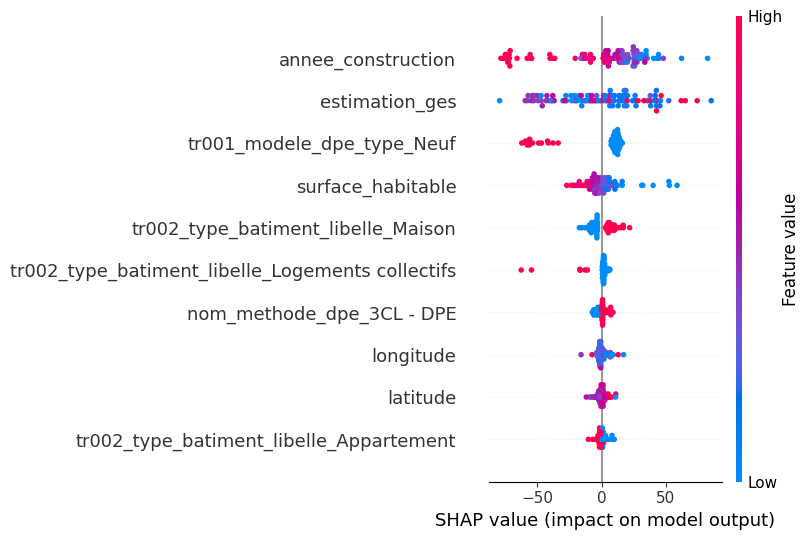

In [174]:
shap_summary_for_model(hgb_model_st, X_train, "HistGradientBoosting (sans tuning)")


📊 SHAP Summary pour XGBoost (avec tuning)


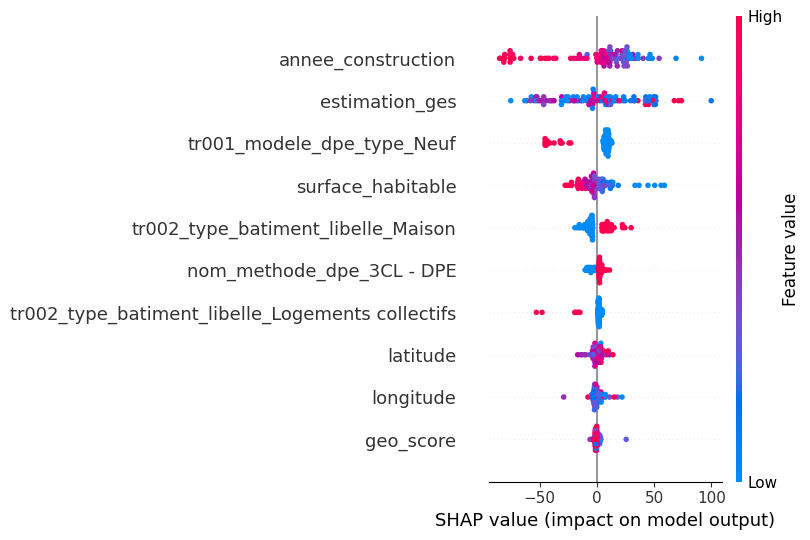

In [176]:
shap_summary_for_model(xgb_model, X_train, "XGBoost (avec tuning)")

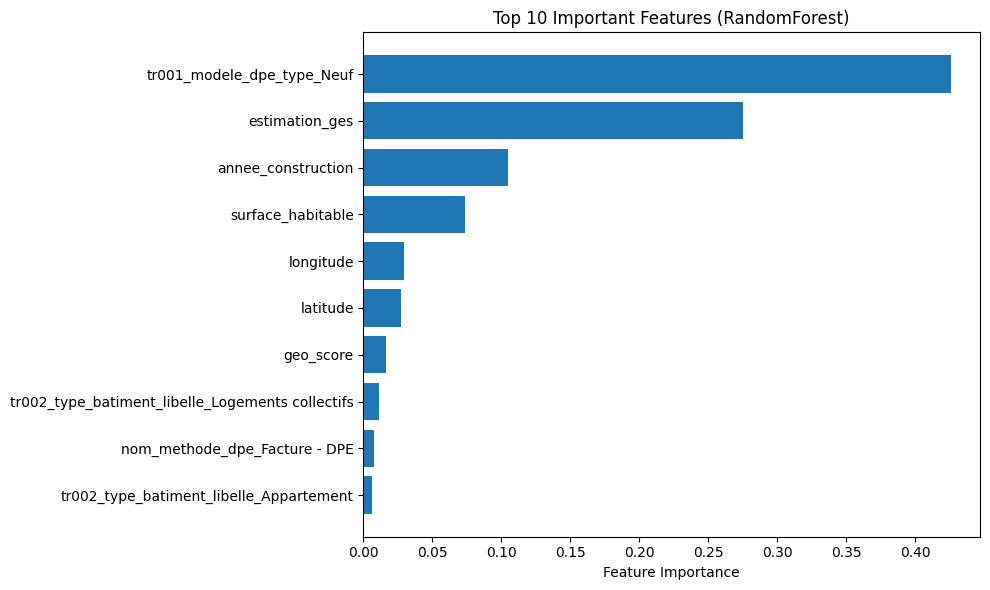

In [179]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances and feature names
importances = rf_model_st.feature_importances_
features = X_train.columns

# Sort top 10 features
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[indices][::-1], align='center')
plt.yticks(range(10), [features[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (RandomForest)")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

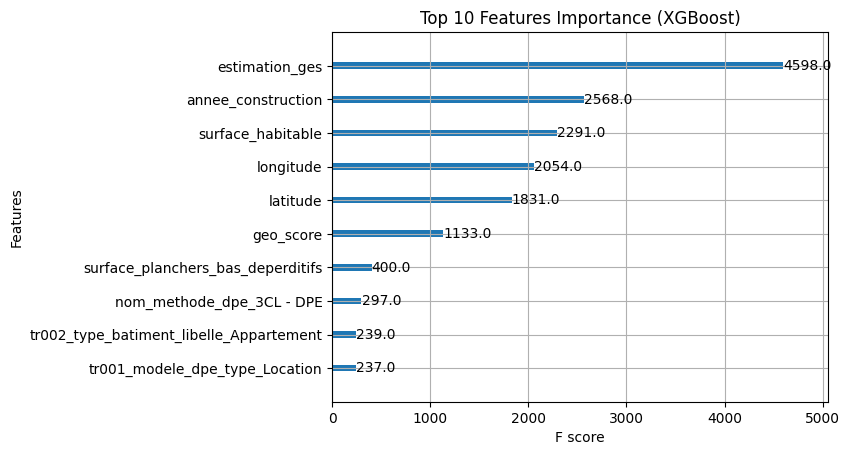

In [177]:
# see features importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title("Top 10 Features Importance (XGBoost)")
plt.show()


In [197]:
categorical_encoded_df.columns

Index(['nom_methode_dpe_3CL - DPE', 'nom_methode_dpe_ECS',
       'nom_methode_dpe_Facture - DPE', 'nom_methode_dpe_Th-BCE',
       'nom_methode_dpe_Th-C-E', 'tr001_modele_dpe_type_Copropriété',
       'tr001_modele_dpe_type_Location', 'tr001_modele_dpe_type_Neuf',
       'tr001_modele_dpe_type_Vente',
       'tr002_type_batiment_libelle_Appartement',
       'tr002_type_batiment_libelle_Logements collectifs',
       'tr002_type_batiment_libelle_Maison'],
      dtype='object')

In [198]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
import pandas as pd
import joblib

# Recharger les données d'entraînement utilisées pour créer le modèle
# X_train = pd.read_csv("X_train.csv") ou autre source

quantitative_cols = ['surface_habitable', 'estimation_ges', 'annee_construction', 'surface_planchers_bas_deperditifs', 'geo_score','longitude','latitude']  # 8 colonnes
categorical_cols = ['nom_methode_dpe', 'tr001_modele_dpe_type', 'tr002_type_batiment_libelle']  # 3 colonnes

# RobustScaler pour quanti
robust_scaler = RobustScaler()
robust_scaler.fit(X_train[quantitative_cols])


# Sauvegarde maintenant
joblib.dump(robust_scaler, 'robust_scaler.pkl')

['robust_scaler.pkl']

In [199]:
from joblib import load
import numpy as np

# Charger ton scaler
scaler = load("robust_scaler.pkl")

# Exemple de données utilisateur
user_quant = [[90, 60, 1980, 80, 1.2, 1.5, 46.7]]  # dans le même ordre que X_train

# Normaliser
scaled_quant = scaler.transform(user_quant)


C:\Users\tarek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [214]:
scaled_quant

array([[9.02360468e+01, 6.01785185e+01, 1.93170732e+03, 8.00000000e+01,
        1.20000000e+00, 1.51441464e+00, 4.64360459e+01]])

In [212]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import joblib

# Exemple d'une ligne par catégorie
df_fake = pd.DataFrame({
    'nom_methode_dpe': ['3CL - DPE', 'Facture - DPE', 'Th-C-E', 'ECS', 'Th-BCE'],
    'tr001_modele_dpe_type': ['Location', 'Vente', 'Neuf', 'Copropriété', 'Location'],
    'tr002_type_batiment_libelle': ['Appartement', 'Maison', 'Logements collectifs', 'Maison', 'Appartement']
})

# Initialiser le OneHotEncoder
onehot_encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')

# Fit avec les données factices (juste pour apprendre les colonnes)
onehot_encoder.fit(df_fake)

# Sauvegarder l’encodeur pour l’utiliser plus tard
joblib.dump(onehot_encoder, 'onehot_encoder.pkl')

# Vérifier les colonnes créées
print(onehot_encoder.get_feature_names_out())

['nom_methode_dpe_3CL - DPE' 'nom_methode_dpe_ECS'
 'nom_methode_dpe_Facture - DPE' 'nom_methode_dpe_Th-BCE'
 'nom_methode_dpe_Th-C-E' 'tr001_modele_dpe_type_Copropriété'
 'tr001_modele_dpe_type_Location' 'tr001_modele_dpe_type_Neuf'
 'tr001_modele_dpe_type_Vente' 'tr002_type_batiment_libelle_Appartement'
 'tr002_type_batiment_libelle_Logements collectifs'
 'tr002_type_batiment_libelle_Maison']


In [213]:
import pandas as pd
import joblib
from sklearn.preprocessing import OneHotEncoder

# 🔹 1. Charger l’encodeur sauvegardé
encoder = joblib.load("onehot_encoder.pkl")

# 🔹 2. Créer une ligne utilisateur simulée
user_input = pd.DataFrame({
    'nom_methode_dpe': ['3CL - DPE'],
    'tr001_modele_dpe_type': ['Vente'],
    'tr002_type_batiment_libelle': ['Maison']
})

# 🔹 3. Encoder la ligne avec l’encodeur appris
encoded_array = encoder.transform(user_input)

# 🔹 4. Transformer en DataFrame avec noms de colonnes
encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(),
    index=user_input.index
)

# 🔹 5. Affichage du résultat
print("✅ Input utilisateur encodé :\n")
print(encoded_df)

✅ Input utilisateur encodé :

   nom_methode_dpe_3CL - DPE  nom_methode_dpe_ECS  \
0                        1.0                  0.0   

   nom_methode_dpe_Facture - DPE  nom_methode_dpe_Th-BCE  \
0                            0.0                     0.0   

   nom_methode_dpe_Th-C-E  tr001_modele_dpe_type_Copropriété  \
0                     0.0                                0.0   

   tr001_modele_dpe_type_Location  tr001_modele_dpe_type_Neuf  \
0                             0.0                         0.0   

   tr001_modele_dpe_type_Vente  tr002_type_batiment_libelle_Appartement  \
0                          1.0                                      0.0   

   tr002_type_batiment_libelle_Logements collectifs  \
0                                               0.0   

   tr002_type_batiment_libelle_Maison  
0                                 1.0  
